<a href="https://colab.research.google.com/github/Cyanjiner/CAPS/blob/main/math_corpus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Colab workspace
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ROOT_FOLDER = "/content/drive/My Drive/transcript_analysis/"
DATA_FOLDER = ROOT_FOLDER + "data/"

RAW_FOLDER = DATA_FOLDER + "raw/"
CLEAN_FOLDER = DATA_FOLDER + "clean/"
MODELS_FOLDER = DATA_FOLDER + "models/"
LOG_DIR = MODELS_FOLDER + "runs/"

In [ ]:
import pandas as pd
from numpy import NaN
import re

# Load all math corpora

- ✅ `ssdf` (`ccss_text.csv`) -- Common Core State Standards

- ✅ `imdf` (`IM_text.csv`) | `math_lang/imdf_sentence_level.csv` -- [Illustrative Mathematics](https://illustrativemathematics.blog/2020/03/26/im-talking-math/)

- ✅ `tdf` (`talk_math.csv`) & `math_lang/talk_math_all.csv | talk_math_sentence.csv`

- `sfdf` (`SFUSD/sfusd_mathtalks.csv`) -- San Francisco Unified School District (SFUSD) Elementary (grade 3-5) Math Talks Bank [orginal resource link](?)

- ✅ `edf` (`engageNY/full_lesson_text.csv`)

- 🤔 (pending for usage) `gdf` (`math_glossary.csv`) -- [CCSS Mathematics Glossary](https://web.archive.org/web/20220206180509/http://www.corestandards.org/Math/Content/mathematics-glossary/)
    - _I think we just include it as part of the base "corpus"


In [ ]:
ssdf = pd.read_csv(DATA_FOLDER + "ccss_text.csv")
imdf = pd.read_csv(DATA_FOLDER + "IM_text.csv")
tdf = pd.read_csv(DATA_FOLDER + "talk_math.csv")
tdf2 = pd.read_csv(DATA_FOLDER + "tdf2.csv")
gdf = pd.read_csv(DATA_FOLDER + "math_glossary.csv")
sfdf = pd.read_csv(DATA_FOLDER + "SFUSD/sfusd_mathtalks.csv")
edf = pd.read_csv(DATA_FOLDER + "engageNY/full_lesson_text.csv")
kadf = pd.read_pickle(DATA_FOLDER + "khan_aca.pkl")

## Talking Math

In [ ]:
tdf2.head()

,grade,lesson,standard,text
0,K,Invitational 1,NA,"[What kinds of toys do you see?, What can you ..."
1,1,Invitational 1,(K.MD and 1.MD),[How many toys are round? How many have straig...
2,2,Invitational 1,(1.MD and 2.MD.10),"[Complete the sentences:, There are 2 more ___..."
3,3,Invitational 1,(2.MD),"[Pick four kinds of toys and count them. , If ..."
4,4,Invitational 1,3.MD,[These are the lengths of the cars in the pict...


### Clean up Talking Math

In [ ]:
import re

In [ ]:
with open(DATA_FOLDER + "talking_math.txt", "r") as file:
  tm_text = file.read()

In [ ]:
def extract_paren_substring(string):
    start = string.index("(")
    end = string.index(")")
    substring = string[start+1:end]
    return string.replace('('+ substring + ')', ""), substring

In [ ]:
extract_paren_substring('(5.NF.B.7) How much juice could all of the oranges in the picture produce?')

(' How much juice could all of the oranges in the picture produce?',
 '5.NF.B.7')

In [ ]:
def split_grade_section(lesson_text):
  grade_content = re.split(r"(Grade K+|Grade \d+)", lesson_text)[1:]
  grade_dict = {}
  for j in range(len(grade_content)):
    g_content = grade_content[j]
    if j % 2 == 0: # even index --> grade_content[j] is the separator
      index = grade_content[j]
      #g_text = grade_content[j+1].strip().split('\n')
      g_text = re.sub(r'\s+', ' ', grade_content[j+1])
      g_text = re.sub('Talking Math','', g_text)
      text_list = re.split(r'(?<=[.!?]\s)+',g_text) # split by punctuation characters
      # filtering out empty string & any element w/ "Talking Math" from the g_text list
      text_list = list(filter(None, text_list))
      #get standard if there is one
      for i in range(len(text_list)):
         if  '(' and ')' in text_list[i]:
           new_s, standard = extract_paren_substring(text_list[i])
           text_list[i] = new_s
         else:
           standard = 'NA'
         result = {'standard': standard, "text": [text for text in text_list if text.strip()]}

      grade_dict[index] = result
      #grade_dict[index] = grade_content[j+1]
  return grade_dict

In [ ]:
main_section = re.split(r"(Invitational \d+|Day \d+)", tm_text)
lesson = []
text = []
for i, content in enumerate(main_section[1:]):
  if i % 2 != 0:
    lesson_text = content # if even index --> content is the text follows by lesson
    grade_dict = split_grade_section(lesson_text)
    text.append(grade_dict)
  else: # if odd index --> content is the separator (i.e. lesson index)
    lesson_name = content
    lesson.append(lesson_name)
d = {'lesson': lesson, "text": text}

In [ ]:
d['text'][1]

{'Grade 4': {'standard': '3.MD',
  'text': [' These are the lengths of the cars in the picture, organized by color: Turquoise 1 ¾ inch Yellow 1 ¼ inch Red 1 ½ inch Green 1 ¾ inch Orange 1 ¾ inch Describe how you would make a line plot about the length of the cars. ']},
 'Grade 5': {'standard': '4.MD.4',
  'text': [' These are the lengths of the blocks in the picture, organized by color: Turquoise 1 ¼ inch Yellow 1 ½ inch Red 1 ½ inch Green 1 ⅜ inch Orange 1 ½ inch Describe how you would make a line plot of this data about the length of the cars. ']}}

In [ ]:
d['text'][1]['Grade 4']['text'][0][83]

'¾'

In [ ]:
n = len(d['lesson'])
talk_math_dict = []
for i in range(n):
  lesson_index = d['lesson'][i]
  grade_dict = d['text'][i]
  for grade, values in grade_dict.items():
    grade_name = grade.split(" ")[1]
    standard = values['standard']
    text = values['text']
    talk_math_dict.append({'grade': grade_name, 'lesson':lesson_index, 'standard': standard, 'text': text})

In [ ]:
tdf2 = pd.DataFrame(talk_math_dict)

In [ ]:
tdf2.head()

,grade,lesson,standard,text
0,K,Invitational 1,NA,"[ What kinds of toys do you see? , What can yo..."
1,1,Invitational 1,K.MD and 1.MD,"[ How many toys are round? , How many have str..."
2,2,Invitational 1,1.MD and 2.MD.10,[ Complete the sentences: There are 2 more ___...
3,3,Invitational 1,2.MD,"[ Pick four kinds of toys and count them. , If..."
4,4,Invitational 1,3.MD,[ These are the lengths of the cars in the pic...


In [ ]:
#from google.colab import files
#tdf2.to_csv("tdf2.csv")
#files.download('tdf2.csv')
tdf2.to_csv(DATA_FOLDER + "math_lang/talk_math_all.csv")

In [ ]:
# lines = [x.strip() for x in lines if x.strip() != '']
# lines
tm_text

"Talking Math\nLaunch\nWhat math questions could you ask about this picture?\nGrade K\nWhat kinds of toys do you see?\nWhat can you tell me about the toys?\nInvitational 1\nLink to the picture\n\n\n\n\nGrade K\nWhat kinds of toys do you see?\n\n\nWhat can you tell me about the toys?\n\n\nGrade 1\nHow many toys are round? How many have straight sides?\n\n\nDo you think there are more round toys or toys with straight sides? Why?\n\n\n(K.MD and 1.MD)\nGrade 2\nComplete the sentences:\nThere are 2 more ________ than _______.\nThere are 8 __________.\n\n\nIn this picture there are groups of___________.\nThe number of ___________ is less than the number of __________.\n\n\n(1.MD and 2.MD.10)\nGrade 3\nPick four kinds of toys and count them. \nIf you made a picture graph about the number of each kind, what could you use as a symbol for each toy?\n\n\n(2.MD)\n             Talking Math\nInvitational 1\nFocus on Data\n\n\nNote: Invitational prompts are sometimes tagged to prior grade level stand

### Talking Math -- Sentence Level

In [ ]:
tdf2 # filter by grade 3 view

,grade,lesson,standard,text
0,K,Invitational 1,NA,"[ What kinds of toys do you see? , What can yo..."
1,1,Invitational 1,K.MD and 1.MD,"[ How many toys are round? , How many have str..."
2,2,Invitational 1,1.MD and 2.MD.10,[ Complete the sentences: There are 2 more ___...
3,3,Invitational 1,2.MD,"[ Pick four kinds of toys and count them. , If..."
4,4,Invitational 1,3.MD,[ These are the lengths of the cars in the pic...
...,...,...,...,...
644,1,Day 95,1.MD.A.2,"[ Find some of these objects in your home. , H..."
645,2,Day 95,2.MD.A.1,"[ There are rulers in this picture. , What can..."
646,3,Day 95,3.MD.B.4,[ Find 3 of the objects similar to those in th...
647,4,Day 95,4.MD.A.1,[ The longer paint brushes in the picture are ...


In [ ]:
import pandas as pd

In [ ]:
type(tdf2.iloc[0]['text'])

list

In [ ]:
# convert text column to list
#tdf2['text'] = tdf2['text'].apply(lambda x: eval(x))
# split the row into multiple rows using explode
tdf2_by_sentence = tdf2.explode('text')
tdf2_by_sentence.to_csv(DATA_FOLDER + "math_lang/talk_math_sentence_level.csv")

### Talking Math sentence level with domains and clusters

#### Talking Math from original (i did this before I recognized that you had done it better)

In [ ]:
tdf = pd.read_csv(DATA_FOLDER + "talk_math.csv")
tdf.standard = tdf.standard.apply(eval)
tdf.text = tdf.text.apply(eval)
tdf['grade'] = tdf.grade.apply(lambda x: x[-1])
tdf.standard = tdf.text.apply(lambda x: " ".join(x)).str.extract('\((?P<standard_raw>[A-Z0-9]?[.][A-Z0-9. ,]+.*?)\)',expand=True).standard_raw.str.replace(' ','').str.split('and|,')
tdf.standard = tdf.text.apply(lambda x: " ".join(x)).str.extract('\((?P<standard_raw>[A-Z0-9]?[.][A-Z0-9. ,]+.*?)\)',expand=True).standard_raw.str.replace(' ','').str.split('and|,')
tdf = tdf.explode('standard')
tdf = tdf.explode('text')
tdf = pd.concat([tdf,tdf.standard.str.split(".",expand=True).rename(columns = {0:'std_grade',1:'domain',2:'cluster',3:'standard_number',4:'strand'})],axis = 1).reset_index().drop(columns=["Unnamed: 0","index"])
tdf = tdf[tdf.text.apply(len) >= 20]
tdf


,grade,standard,text,text_type,lesson,std_grade,domain,cluster,standard_number,strand
0,K,K.MD,What kinds of toys do you see?,t_questions,Invitational,K,MD,None,None,None
1,K,K.MD,What can you tell me about the toys?,t_questions,Invitational,K,MD,None,None,None
5,K,K.MD,What kinds of toys do you see?,t_questions,Invitational,K,MD,None,None,None
6,K,K.MD,What can you tell me about the toys?,t_questions,Invitational,K,MD,None,None,None
8,K,K.MD,How many toys are round? How many have straigh...,t_questions,Invitational,K,MD,None,None,None
...,...,...,...,...,...,...,...,...,...,...
1094,1,1.MD.A.2,Find some of these objects in your home. How m...,t_questions,95,1,MD,A,2,None
1096,2,2.MD.A.1,There are rulers in this picture. What can you...,t_questions,95,2,MD,A,1,None
1098,3,3.MD.B.4,Find 3 of the objects similar to those in the ...,t_questions,95,3,MD,B,4,None
1099,4,4.MD.A.1,The longer paint brushes in the picture are ab...,t_questions,95,4,MD,A,1,None


#### Getting standard domains using Jiner's sentence level code

In [ ]:
tdf2.standard = tdf2.standard.apply(lambda x: [i.replace("(","").replace(")","").strip() for i in str(x).split('and')])
tdf2.text = tdf2.text.apply(eval)
tdf2 = tdf2.explode('standard')
tdf2 = tdf2.explode('text')


In [ ]:
tdf2.standard.head(50)

0                      NaN
1          (K.MD and 1.MD)
2       (1.MD and 2.MD.10)
3                   (2.MD)
4                     3.MD
5                 (4.MD.4)
6                      NaN
7                     K.CC
8        K.OA.4 and 1.OA.2
9                   1.OA.1
10    (2.NBT.2 and 3.OA.1)
11       3.OA.3 and 4.OA.3
12      4.NBT.4 and 5.OA.1
13                     NaN
14         K.G.A and K.G.B
15       (K.G.4 and 1.G.A)
16     (1.OA.2  and 2.G.2)
17       2.OA.4 and 3.MD.C
18                  3.MD.7
19       4.MD.3 and 5.MD.C
20                     NaN
21                    K.MD
22         (K.MD.2, .MD.1)
23       1.MD.2 and 2.MD.1
24    (2.MD.3. and 3.MD.4)
25                  3.MD.4
26    (4.MD.1 and 5.MD. 1)
27                     NaN
28       K.CC.2 and K.CC.3
29       K.OA.4 and 1.OA.1
30     (1.OA.1 and 2.OA.1)
31     (2.OA.3 and 3.OA.1)
32               (3.NBT.2)
33    (4.NF.6 and 5.NBT.7)
34                     NaN
35                 K.G.B.5
36                 1.G.A.2
3

In [ ]:
tdf2.standard.value_counts()

nan           93
3.OA.A.3      22
1.OA.A.1      22
5.MD.A.1      22
1.G.A.2       21
              ..
3.OA.B.6       1
5.NBT.A.4      1
4.NF.B.3.C     1
K.CC.C.7       1
5.G.B          1
Name: standard, Length: 202, dtype: int64

###

## IM text

In [ ]:
imdf.head()

,Unnamed: 0,grade,lesson,title,standard,ts_text,t_guide_all,url,material,full_page_text,module,full_text
0,0,1,Lesson 1,What Do You Know About Math?,1.OA.C.5,['“What are some different ways you and your p...,"['1.OA.C.5', 'What Do You Know About _____?', ...",https://curriculum.illustrativemathematics.org...,lesson_activity,NaN,1.0,\nLesson 1\nCount and Add \n\nPreparationLesso...
1,0,1,Lesson 1,"Revisit Counting Collections, Up to 20",1.OA.C.5,['“What are some different ways you and your p...,"['1.OA.C.5', 'What Do You Know About _____?', ...",https://curriculum.illustrativemathematics.org...,lesson_activity,NaN,1.0,\nLesson 1\nCount and Add \n\nPreparationLesso...
2,0,1,Lesson 1,"Introduce: Number Race, Add to 10",1.OA.C.5,['“What are some different ways you and your p...,"['1.OA.C.5', 'What Do You Know About _____?', ...",https://curriculum.illustrativemathematics.org...,lesson_activity,NaN,1.0,\nLesson 1\nCount and Add \n\nPreparationLesso...
3,0,1,Lesson 2,Choral Count: Count to 41,K.CC.A.1,['“How did you know which expression matched e...,"['K.CC.A.1', 'Choral Count', '“Count by 1, sta...",https://curriculum.illustrativemathematics.org...,lesson_activity,NaN,1.0,\nLesson 2\nExplore Expressions and Sums \n\nP...
4,0,1,Lesson 2,Matching Dot Cards and Expressions,K.CC.A.1,['“How did you know which expression matched e...,"['K.CC.A.1', 'Choral Count', '“Count by 1, sta...",https://curriculum.illustrativemathematics.org...,lesson_activity,NaN,1.0,\nLesson 2\nExplore Expressions and Sums \n\nP...


In [ ]:
imdf = pd.read_csv(DATA_FOLDER + "IM_text.csv")
imdf = imdf.explode('ts_text')
imdf = pd.concat([imdf,imdf.ts_text.str.extract('“(?P<teacher_text>.*?)”.*\((?P<student_text>.*?)\)',expand=True)],axis = 1)
imdf.t_guide_all = imdf.t_guide_all.apply(eval).apply(lambda x: " ".join(x[1:]))
imdf = pd.concat([imdf,imdf.standard.str.split(".",expand=True).rename(columns = {0:'std_grade',1:'domain',2:'cluster',3:'standard_number',4:'strand'})],axis =1)


In [ ]:
imdf.t_guide_all.iloc[0]

'What Do You Know About _____? Groups of 2 Display the question. “What do you know about math?” 1 minute: quiet think time Record responses. “Today, you will get to do math in different ways.” K.CC.B MLR8 Engagement Collections of objects Counting Collections Stages 1 and 2 Recording Sheet 10-Frame Standard Create one collection of up to 20 objects such as buttons, counters, connecting cubes, paper clips, square tiles for each group of 2. Groups of 2 Give each group a collection of objects, two recording sheets,\xa0and access to 10-frames. Show students a collection\xa0of 10–20 objects. “We are going to start with some counting. You and your partner will get a collection of objects like this one. Your job is to figure out how many objects are in your collection and show how many.” “What are some different ways you and your partner can work together to count the collection?” (One person can count first and then the next can count to see if they get the same amount. We can take turns mov

,Unnamed: 0,grade,lesson,title,standard,ts_text,t_guide_all,url,material,full_page_text,module,full_text,teacher_text,student_text
0,0,1,Lesson 1,What Do You Know About Math?,1.OA.C.5,“What are some different ways you and your par...,1.OA.C.5 What Do You Know About _____? Groups ...,https://curriculum.illustrativemathematics.org...,lesson_activity,NaN,1.0,\nLesson 1\nCount and Add \n\nPreparationLesso...,What are some different ways you and your part...,One person can count first and then the next c...
0,0,1,Lesson 1,What Do You Know About Math?,1.OA.C.5,“How did you keep track of the objects as you ...,1.OA.C.5 What Do You Know About _____? Groups ...,https://curriculum.illustrativemathematics.org...,lesson_activity,NaN,1.0,\nLesson 1\nCount and Add \n\nPreparationLesso...,How did you keep track of the objects as you c...,We put each object in a pile after we counted ...
0,0,1,Lesson 1,What Do You Know About Math?,1.OA.C.5,“How did they show their count?” (They drew tw...,1.OA.C.5 What Do You Know About _____? Groups ...,https://curriculum.illustrativemathematics.org...,lesson_activity,NaN,1.0,\nLesson 1\nCount and Add \n\nPreparationLesso...,How did they show their count?,They drew twelve circles. They wrote the numbe...
0,0,1,Lesson 1,What Do You Know About Math?,1.OA.C.5,“What does it look and sound like to do math t...,1.OA.C.5 What Do You Know About _____? Groups ...,https://curriculum.illustrativemathematics.org...,lesson_activity,NaN,1.0,\nLesson 1\nCount and Add \n\nPreparationLesso...,What does it look and sound like to do math to...,We talked to each other and to the teacher. We...
1,0,1,Lesson 1,"Revisit Counting Collections, Up to 20",1.OA.C.5,“What are some different ways you and your par...,1.OA.C.5 What Do You Know About _____? Groups ...,https://curriculum.illustrativemathematics.org...,lesson_activity,NaN,1.0,\nLesson 1\nCount and Add \n\nPreparationLesso...,What are some different ways you and your part...,One person can count first and then the next c...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2308,0,5,Lesson 18,Which One Doesn't Belong? Design 1,5.MD.C.3,“What were the most important things about you...,5.MD.C.3 Which One Doesn’t Belong? Groups of 2...,https://curriculum.illustrativemathematics.org...,lesson_activity,NaN,8.0,\nLesson 18\n Which One Doesn’t Belong?\t \n\n...,What were the most important things about your...,I was able to get three different shapes where...
2309,0,5,Lesson 18,Which One Doesn't Belong? Design 2,5.MD.C.3,“What did the writer of this activity have to ...,5.MD.C.3 Which One Doesn’t Belong? Groups of 2...,https://curriculum.illustrativemathematics.org...,lesson_activity,NaN,8.0,\nLesson 18\n Which One Doesn’t Belong?\t \n\n...,What did the writer of this activity have to p...,"the number of sides, the types of angles or co..."
2309,0,5,Lesson 18,Which One Doesn't Belong? Design 2,5.MD.C.3,“What were the most important things about you...,5.MD.C.3 Which One Doesn’t Belong? Groups of 2...,https://curriculum.illustrativemathematics.org...,lesson_activity,NaN,8.0,\nLesson 18\n Which One Doesn’t Belong?\t \n\n...,What were the most important things about your...,I was able to get three different shapes where...
2310,0,5,Lesson 18,Which One Doesn't Belong? Design 3,5.MD.C.3,“What did the writer of this activity have to ...,5.MD.C.3 Which One Doesn’t Belong? Groups of 2...,https://curriculum.illustrativemathematics.org...,lesson_activity,NaN,8.0,\nLesson 18\n Which One Doesn’t Belong?\t \n\n...,What did the writer of this activity have to p...,"the number of sides, the types of angles or co..."


### Decompose by sentence level

In [ ]:
imdf['ts_text'] = imdf['ts_text'].apply(lambda x: eval(x))

In [ ]:
# decompose by sentence level
imdf_sentence = imdf.explode('ts_text')

In [ ]:
imdf_sentence.iloc[0]['ts_text']

'“What are some different ways you and your partner can work together to count the collection?” (One person can count first and then the next can count to see if they get the same amount. We can take turns moving an object and counting a number.)'

In [ ]:
imdf_sentence.iloc[3]['ts_text']

'“What does it look and sound like to do math together as a mathematical community?” (We talked to each other and to the teacher. We had quiet time to think. You asked us questions. We shared our ideas. We thought about the math ideas and words we knew. You were writing down our answers. You were waiting quietly until we gave the answers.)'

In [ ]:
imdf_sentence.iloc[100]['ts_text']

'“Today we answered questions about data represented with tally marks and numbers. Which representation do you prefer? Why do you like that representation better?” (I prefer tally marks because I don’t have to use cubes or make a drawing to add the numbers together. I prefer the numbers because I don’t have to count.)'

In [ ]:
s = re.search(r'“(.*)”\((.*)\)',imdf_sentence.iloc[100]['ts_text'])

In [ ]:
double_quotes = re.findall(r'“(.*?)”', imdf_sentence.iloc[100]['ts_text'])

In [ ]:
double_quotes

['Today we answered questions about data represented with tally marks and numbers. Which representation do you prefer? Why do you like that representation better?']

In [ ]:
parentheses = re.findall(r'\((.*?)\)', imdf_sentence.iloc[100]['ts_text'])

In [ ]:
parentheses

['I prefer tally marks because I don’t have to use cubes or make a drawing to add the numbers together. I prefer the numbers because I don’t have to count.']

In [ ]:
imdf_sentence['teacher_text']

0        
0        
0        
0        
1        
       ..
2308     
2309     
2309     
2310     
2310     
Name: teacher_text, Length: 12853, dtype: object

### extract teacher & student text respectively into new vars

In [ ]:
## extract teacher & student text respectively into new vars
from numpy import NaN
teacher_text = []
student_text = []
for i in range(len(imdf_sentence)):
  ts_text = imdf_sentence.iloc[i]['ts_text']
  if type(ts_text) is str:
    t_text = re.findall(r'“(.*?)”', ts_text)
    s_text = re.findall(r'\((.*?)\)', ts_text)
    if len(t_text) != 0:
      teacher_text.append(t_text[0])
    else:
      teacher_text.append(NaN)

    if len(s_text) != 0:
      student_text.append(s_text[0])
    else:
      student_text.append(NaN)
  else:
    teacher_text.append(NaN)
    student_text.append(NaN)
ts_text_dict = {'t_text':teacher_text, 's_text': student_text}

In [ ]:
len(ts_text_dict['t_text']) == len(imdf_sentence['ts_text'])

True

In [ ]:
t_texts_dt = pd.DataFrame(ts_text_dict)
t_texts_dt.head()

,t_text,s_text
0,What are some different ways you and your part...,One person can count first and then the next c...
1,How did you keep track of the objects as you c...,We put each object in a pile after we counted ...
2,How did they show their count?,They drew twelve circles. They wrote the numbe...
3,What does it look and sound like to do math to...,We talked to each other and to the teacher. We...
4,What are some different ways you and your part...,One person can count first and then the next c...


### Merge with main data

In [ ]:
t_texts_dt.reset_index(inplace=True, drop=True)

In [ ]:
imdf_sub = imdf_sentence[['grade','lesson','standard','ts_text']] # get a subset by selecting a few columns

In [ ]:
imdf_sub.reset_index(inplace=True, drop=True)

In [ ]:
imdf_sentence_level = pd.concat([t_texts_dt, imdf_sub],
          axis=1, # axis = 0 binding rows, = 1 bind by cols
          #how = 'inner'
          ignore_index=True)

In [ ]:
imdf_sentence_level.columns = ['index','teacher_text','student_text','grade','lesson','standard','ts_text']

In [ ]:
imdf_sentence_level

,index,teacher_text,student_text,grade,lesson,standard,ts_text
0,0,What are some different ways you and your part...,One person can count first and then the next c...,1,Lesson 1,1.OA.C.5,“What are some different ways you and your par...
1,1,How did you keep track of the objects as you c...,We put each object in a pile after we counted ...,1,Lesson 1,1.OA.C.5,“How did you keep track of the objects as you ...
2,2,How did they show their count?,They drew twelve circles. They wrote the numbe...,1,Lesson 1,1.OA.C.5,“How did they show their count?” (They drew tw...
3,3,What does it look and sound like to do math to...,We talked to each other and to the teacher. We...,1,Lesson 1,1.OA.C.5,“What does it look and sound like to do math t...
4,4,What are some different ways you and your part...,One person can count first and then the next c...,1,Lesson 1,1.OA.C.5,“What are some different ways you and your par...
...,...,...,...,...,...,...,...
12848,12848,What were the most important things about your...,I was able to get three different shapes where...,5,Lesson 18,5.MD.C.3,“What were the most important things about you...
12849,12849,What did the writer of this activity have to p...,"the number of sides, the types of angles or co...",5,Lesson 18,5.MD.C.3,“What did the writer of this activity have to ...
12850,12850,What were the most important things about your...,I was able to get three different shapes where...,5,Lesson 18,5.MD.C.3,“What were the most important things about you...
12851,12851,What did the writer of this activity have to p...,"the number of sides, the types of angles or co...",5,Lesson 18,5.MD.C.3,“What did the writer of this activity have to ...


In [ ]:
imdf_sentence_level.to_csv(DATA_FOLDER + 'math_lang/imdf_sentence_level.csv')

## Engage NY

In [ ]:
edf

In [ ]:
edf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5873 entries, 0 to 5872
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   5873 non-null   int64 
 1   grade        5873 non-null   object
 2   module       5873 non-null   object
 3   topic        5873 non-null   object
 4   lesson       5873 non-null   int64 
 5   objective    5836 non-null   object
 6   lesson_part  5873 non-null   object
 7   standard     5873 non-null   object
 8   text_type    5873 non-null   object
 9   text         5873 non-null   object
dtypes: int64(2), object(8)
memory usage: 459.0+ KB


In [ ]:
edf['grade'].unique()

array(['g4', 'g5', 'g3', 'g6'], dtype=object)

In [ ]:
edf['grade'] = edf['grade'].map(lambda x: x.lstrip('g')) # remove all g in grade
# check levels again
edf['grade'].unique()

array(['4', '5', '3', '6'], dtype=object)

In [ ]:
# get a dialogue subset
edf_talk = edf[edf['text_type']=='ts_dialogue'][['grade','standard','lesson_part','text']]
# reset index
edf_talk.reset_index(inplace=True, drop=True)

In [ ]:
# change text variable to list
edf_talk['text'] = edf_talk['text'].apply(lambda x: eval(x))
edf_talk['text'][0]

[['T:',
  '(Project place value chart to the thousands.)  Show 4 ones as place value disks.  Write the number below it.'],
 ['S:', '(Draw 4 ones disks and write 4 below it.) '],
 ['T:', 'Show 4 tens disks, and write the number below it.'],
 ['S:', '(Draw 4 tens disks and write 4 at the bottom of the tens column.)'],
 ['T:', 'Say the number in unit form.'],
 ['S:', '4 tens 4 ones.'],
 ['T:', 'Say the number in standard form.'],
 ['S:', '44.']]

In [ ]:
edf_talk_sentence = edf_talk.explode('text')
edf_talk_sentence.reset_index(inplace=True, drop=True)

In [ ]:
edf_talk_sentence['text'][0]

['T:',
 '(Project place value chart to the thousands.)  Show 4 ones as place value disks.  Write the number below it.']

In [ ]:
edf_talk_sentence['text'][1]

['S:', '(Draw 4 ones disks and write 4 below it.) ']

In [ ]:
edf_talk_sentence['text'][1][0][:2]

'S:'

In [ ]:
edf_talk_sentence['text'][30258]

['Ms. Johnson and Ms. Siple were folding report cards to send home to parents.  The ratio of the number of report cards Ms. Johnson folded to the number of report cards Ms. Siple folded is .  At the end of the day, Ms. Johnson and Ms. Siple folded a total of  report cards.  How many did each person fold? ']

In [ ]:
edf_talk_sentence['text'][30258][0][:2]

'Ms'

In [ ]:
edf_talk_sentence['talk_source'] = NaN
edf_talk_sentence['clean_text'] = NaN

In [ ]:
edf_talk_sentence

,grade,standard,lesson_part,text,teacher_talk,student_talk,talk_source
0,4,4.NBT.2,Place Value,"[T:, (Project place value chart to the thousan...",(Project place value chart to the thousands.) ...,NaN,NaN
1,4,4.NBT.2,Place Value,"[S:, (Draw 4 ones disks and write 4 below it.) ]",NaN,(Draw 4 ones disks and write 4 below it.),NaN
2,4,4.NBT.2,Place Value,"[T:, Show 4 tens disks, and write the number b...","Show 4 tens disks, and write the number below it.",NaN,NaN
3,4,4.NBT.2,Place Value,"[S:, (Draw 4 tens disks and write 4 at the bot...",NaN,(Draw 4 tens disks and write 4 at the bottom o...,NaN
4,4,4.NBT.2,Place Value,"[T:, Say the number in unit form.]",Say the number in unit form.,NaN,NaN
...,...,...,...,...,...,...,...
30258,6,None,Closing,[Ms. Johnson and Ms. Siple were folding report...,NaN,NaN,NaN
30259,6,None,Closing,"[Ms. Johnson folded report cards, and Ms. Sip...",NaN,NaN,NaN
30260,6,None,Closing,"[At a country concert, the ratio of the number...",NaN,NaN,NaN
30261,6,None,Closing,[There are boys at the country concert. ],NaN,NaN,NaN


### Extract text based on teacher or student & remove instructions

In [ ]:
 for i in range(len(edf_talk_sentence)):
  curr_text = edf_talk_sentence['text'][i]
  # start with T:
  if curr_text[0][:2] == 'T:':
    if len(curr_text) < 2 or len(curr_text[1]) <2 :
      continue
    else:
      edf_talk_sentence['talk_source'][i] = 'teacher_text'
      # need to remove every substrings within parentheses --> those are instructions for movement
      if '(' and ')' in curr_text[1]:
        t_talk, instruction = extract_paren_substring(curr_text[1])
        edf_talk_sentence['clean_text'][i] = t_talk
      else:
        edf_talk_sentence['clean_text'][i] = curr_text[1]
  # start with S:
  elif curr_text[0][:2] == 'S:':
    if len(curr_text) < 2 or len(curr_text[1]) <2 :
      continue
    else:
      edf_talk_sentence['talk_source'][i] = 'student_text'
      if '(' and ')' in curr_text[1]:
        t_talk, instruction = extract_paren_substring(curr_text[1])
        edf_talk_sentence['clean_text'][i] = t_talk
      else:
        edf_talk_sentence['clean_text'][i] = curr_text[1]
  # anything else just continue

In [ ]:
edf_talk_sentence = edf_talk_sentence.drop(columns=['teacher_talk', 'student_talk'])

In [ ]:
edf_talk_sentence['talk_source'].unique()

array(['teacher_text', 'student_text', nan], dtype=object)

In [ ]:
edf_talk_sentence.to_csv(DATA_FOLDER + "math_lang/edf_talk_sentence.csv")
files.download(DATA_FOLDER +'math_lang/edf_talk_sentence.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
edf_talk_sentence

,grade,standard,lesson_part,text,talk_source,clean_text
0,4,4.NBT.2,Place Value,"[T:, (Project place value chart to the thousan...",teacher_text,Show 4 ones as place value disks. Write the...
1,4,4.NBT.2,Place Value,"[S:, (Draw 4 ones disks and write 4 below it.) ]",student_text,
2,4,4.NBT.2,Place Value,"[T:, Show 4 tens disks, and write the number b...",teacher_text,"Show 4 tens disks, and write the number below it."
3,4,4.NBT.2,Place Value,"[S:, (Draw 4 tens disks and write 4 at the bot...",student_text,
4,4,4.NBT.2,Place Value,"[T:, Say the number in unit form.]",teacher_text,Say the number in unit form.
...,...,...,...,...,...,...
30258,6,None,Closing,[Ms. Johnson and Ms. Siple were folding report...,NaN,NaN
30259,6,None,Closing,"[Ms. Johnson folded report cards, and Ms. Sip...",NaN,NaN
30260,6,None,Closing,"[At a country concert, the ratio of the number...",NaN,NaN
30261,6,None,Closing,[There are boys at the country concert. ],NaN,NaN


## SFDF

In [ ]:
sfdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    66 non-null     object
 1   grade         66 non-null     object
 2   lesson        66 non-null     object
 3   objective     66 non-null     object
 4   description   66 non-null     object
 5   teacher_talk  62 non-null     object
 6   student_talk  53 non-null     object
dtypes: object(7)
memory usage: 3.7+ KB


In [ ]:
# check unique values grade has
sfdf['grade'].unique()

array(['4', 'unit 4', 'unit 5', 'unit 3', 'unit 2', 'grade 4'],
      dtype=object)

In [ ]:
sfdf['grade'] = sfdf['grade'].replace(['grade 4','unit 4'], '4')
sfdf['grade'] = sfdf['grade'].replace(['unit 5'], '5')
sfdf['grade'] = sfdf['grade'].replace(['unit 3'], '3')
sfdf['grade'] = sfdf['grade'].replace(['unit 2'], '2')
# check unique values grade has after replacing
sfdf['grade'].unique()

array(['4', '5', '3', '2'], dtype=object)

In [ ]:
sfdf['student_talk'][0]

'Anticipated Student Responses:\nI saw 4 dots in a line going down, then 3 dots in a line going down. 4 + 3 is 7, then 2 more dots in a line going down, 2 + 7 = 9. Then the last dot alone is 1, and 1 + 9 = 10.  4 + 3 + 2 + 1 = 10\nI saw a group of 4 in a diamond on the right. Then I saw leftover was 3 dots on the top left and 3 dots on the bottom left. So I added 3 + 3 + 4 which is 6 + 4, which is 10. 3 + 3 + 4 = 10\nI saw a triangle of three dots on the right, the top left, and the bottom left. So I thought of 3 groups of 3 which is 9, then added the one in the middle which is 10.\n3 + 3 + 3 + 1 = 10 or (3 x 3) + 1 = 10'

In [ ]:
# remove all the Question/Prompt: | Ask: | Question: from text strings
for i in range(len(sfdf)):
  text = sfdf['teacher_talk'][i]
  if text is not NaN:
    sfdf['teacher_talk'][i] = re.sub(r'(Question/Prompt:\s|Ask:\s|Question:\s)', '', text)

In [ ]:
sfdf[['teacher_talk']]

,teacher_talk
0,How many dots do you see? How do you see them?...
1,Description: Ask students Which amount is grea...
2,How many ___ do you see? How do you see them? ...
3,How many ___ do you see? How do you see them? ...
4,Which one doesn’t belong? Why?
...,...
61,What expression might go with this number line...
62,NaN
63,Where does each number go in this diagram?\nAb...
64,Where does each number go in this diagram?\nWi...


## SSDF

In [ ]:
ssdf[['text']]

,text
0,Count to 100 by ones and by tens.
1,Count forward beginning from a given number wi...
2,Write numbers from 0 to 20. Represent a number...
3,Understand the relationship between numbers an...
4,"Count to answer ""how many?"" questions about as..."
...,...
326,"Draw construct, and describe geometrical figur..."
327,Solve real-life and mathematical problems invo...
328,Understand congruence and similarity using phy...
329,Understand and apply the Pythagorean Theorem.


# Building Elementary Discourse Math Language Corpus

## Merging datasets

In [ ]:
imdf_sentence_level = pd.read_csv(DATA_FOLDER + "math_lang/imdf_sentence_level.csv")
talk_math_sentence_level = pd.read_csv(DATA_FOLDER + "math_lang/talk_math_sentence_level.csv")
edf_talk_sentence = pd.read_csv(DATA_FOLDER + "math_lang/edf_talk_sentence.csv")
sfdf = pd.read_csv(DATA_FOLDER + "SFUSD/sfusd_mathtalks.csv")
ssdf = pd.read_csv(DATA_FOLDER + "ccss_text.csv")

In [ ]:
math_df1_t = imdf_sentence_level[['grade','teacher_text']]
math_df1_s = imdf_sentence_level[['grade','student_text']]

In [ ]:
math_df1_t['talk_source'] = 'teacher_text'
math_df1_s['talk_source'] = 'student_text'

<ipython-input-27-8be96c115e83>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  math_df1_t['talk_source'] = 'teacher_text'
<ipython-input-27-8be96c115e83>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  math_df1_s['talk_source'] = 'student_text'


In [ ]:
math_df1_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12853 entries, 0 to 12852
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   grade         12853 non-null  int64 
 1   student_text  12788 non-null  object
 2   talk_source   12853 non-null  object
dtypes: int64(1), object(2)
memory usage: 301.4+ KB


In [ ]:
math_df1_s.columns = ['grade','text','talk_source']
math_df1_t.columns = ['grade','text','talk_source']

In [ ]:
# merge student and teacher text together
math_df1 = pd.concat([math_df1_s, math_df1_t], axis = 0)
math_df1

,grade,text,talk_source
0,1,One person can count first and then the next c...,student_text
1,1,We put each object in a pile after we counted ...,student_text
2,1,They drew twelve circles. They wrote the numbe...,student_text
3,1,We talked to each other and to the teacher. We...,student_text
4,1,One person can count first and then the next c...,student_text
...,...,...,...
12848,5,What were the most important things about your...,teacher_text
12849,5,What did the writer of this activity have to p...,teacher_text
12850,5,What were the most important things about your...,teacher_text
12851,5,What did the writer of this activity have to p...,teacher_text


In [ ]:
# check grade level
math_df1['grade'].unique()

array([1, 2, 3, 4, 5])

In [ ]:
talk_math_sentence_level['talk_source'] = 'teacher_text'
talk_math_sentence_level.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1476 entries, 0 to 1475
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   1476 non-null   int64 
 1   grade        1476 non-null   object
 2   lesson       1476 non-null   object
 3   standard     1364 non-null   object
 4   text         1476 non-null   object
 5   talk_source  1476 non-null   object
dtypes: int64(1), object(5)
memory usage: 69.3+ KB


In [ ]:
# check grade level
talk_math_sentence_level['grade'].unique()

array(['K', '1', '2', '3', '4', '5'], dtype=object)

In [ ]:
talk_math_sentence_level['text']

0                         What kinds of toys do you see? 
1                   What can you tell me about the toys? 
2                               How many toys are round? 
3                          How many have straight sides? 
4       Do you think there are more round toys or toys...
                              ...                        
1471            Can paint brushes be measured in meters? 
1472                                            Explain. 
1473     If all the pencils in the picture were lined ...
1474                     What is this measure in meters? 
1475                                           Explain.  
Name: text, Length: 1476, dtype: object

In [ ]:
# combine with previous data
math_df2 = pd.concat([math_df1,
                      talk_math_sentence_level[['grade','text','talk_source']]],
                     axis = 0)

In [ ]:
math_df2

,grade,text,talk_source
0,1,One person can count first and then the next c...,student_text
1,1,We put each object in a pile after we counted ...,student_text
2,1,They drew twelve circles. They wrote the numbe...,student_text
3,1,We talked to each other and to the teacher. We...,student_text
4,1,One person can count first and then the next c...,student_text
...,...,...,...
1471,4,Can paint brushes be measured in meters?,teacher_text
1472,4,Explain.,teacher_text
1473,5,If all the pencils in the picture were lined ...,teacher_text
1474,5,What is this measure in meters?,teacher_text


In [ ]:
# check grade level
edf_talk_sentence['grade'].unique()
# don't include grade 6 for now
edf_talk_sentence = edf_talk_sentence[edf_talk_sentence['grade'] != 6]
# check grade level again
edf_talk_sentence['grade'].unique()

array([4, 5, 3])

In [ ]:
edf_talk_sentence.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30075 entries, 0 to 30074
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   30075 non-null  int64 
 1   grade        30075 non-null  int64 
 2   standard     30075 non-null  object
 3   lesson_part  30075 non-null  object
 4   text         30075 non-null  object
 5   talk_source  23045 non-null  object
 6   clean_text   20503 non-null  object
dtypes: int64(2), object(5)
memory usage: 1.8+ MB


In [ ]:
edf_sub = edf_talk_sentence[['grade','clean_text','talk_source']].dropna()

In [ ]:
# create a new row storing the length of text
edf_sub['txt_length'] = edf_sub.clean_text.str.len()

# drop rows that len(clean_text) < 5
edf_sub = edf_sub[edf_sub['txt_length'] > 5]

# reset index
edf_sub.reset_index(inplace=True, drop=True)

In [ ]:
edf_sub.columns = ['grade','text','talk_source','txt_length']
edf_sub.head()

,grade,text,talk_source,txt_length
0,4,Show 4 ones as place value disks. Write the...,teacher_text,63
1,4,"Show 4 tens disks, and write the number below it.",teacher_text,49
2,4,Say the number in unit form.,teacher_text,28
3,4,4 tens 4 ones.,student_text,14
4,4,Say the number in standard form.,teacher_text,32


In [ ]:
# merge it with math_df2
math_df = pd.concat([math_df2,
                     edf_sub[['grade','text','talk_source']]],
                    axis = 0,
                    ignore_index = True)
math_df

In [ ]:
# check string length
math_df['txt_length'] = math_df.text.str.len()

In [ ]:
math_df[math_df['txt_length']< 10]
# well I think these can be considered as noise and remove :)

,grade,text,talk_source,txt_length
159,1,\(6 + 2\,student_text,8.0
167,1,\(6 + 2\,student_text,8.0
175,1,\(6 + 2\,student_text,8.0
183,1,\(6 + 2\,student_text,8.0
292,1,4,student_text,1.0
...,...,...,...,...
46239,3,12 tiles.,student_text,9.0
46241,3,6 twos.,student_text,7.0
46253,3,7 threes.,student_text,9.0
46264,3,4 inches!,student_text,9.0


In [ ]:
math_df[math_df['txt_length'] < 15]

,grade,text,talk_source,txt_length
216,1,\(4 + 2 = 6\,student_text,12.0
220,1,\(4 + 2 = 6\,student_text,12.0
224,1,\(4 + 2 = 6\,student_text,12.0
254,1,\(3 + 7 = 10\,student_text,13.0
256,1,\(3 + 4 = 7\,student_text,12.0
...,...,...,...,...
46214,3,Square inches!,student_text,14.0
46231,3,2 × 4 = 1 × 8.,student_text,14.0
46281,3,4 × 7 = 28.,student_text,11.0
46290,3,6 × 8 = 48.,student_text,11.0


In [ ]:
math_df3 = math_df[math_df['txt_length'] > 15]

In [ ]:
math_df3[math_df3['txt_length'] < 20]

,grade,text,talk_source,txt_length
417,1,False. \(4 + 2 = 6\,student_text,19.0
422,1,False. \(4 + 2 = 6\,student_text,19.0
427,1,False. \(4 + 2 = 6\,student_text,19.0
519,1,If \(10 + 4 = 14\,student_text,17.0
526,1,If \(10 + 4 = 14\,student_text,17.0
...,...,...,...,...
46112,3,36 square units!,student_text,16.0
46141,3,"5, 7, 8, and 10.",student_text,16.0
46220,3,What is the area?,teacher_text,17.0
46221,3,8 square inches!,student_text,16.0


In [ ]:
from google.colab import files
math_df3.to_csv("math_df3.csv")
files.download('math_df3.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Remove useless stuff (start w/ a subset first)

e.g.
How do you know?
what did you do?

- incomplete sentences/expressions (maybe)
  - e.g. cross each other

- remove duplicates 18238 duplicates

- non-math
  - e.g. how do you know? what did you do?

In [ ]:
math_test = pd.read_csv(DATA_FOLDER + 'math_lang/math_df3.csv')

In [ ]:
math_test = math_test[math_test['txt_length'] >= 50]

In [ ]:
math_test[['text']]

,text
0,"It’s similar. The fractions are the same, but..."
1,I started by imagining the mat without the pic...
2,The first step is just subtraction. We can do...
3,It does make sense. It couldn’t be put betwee...
4,The sides of the rectangles are all different ...
...,...
15991,How can you find the total area of the rectang...
15992,What number sentence can be used to find the a...
15993,"At your table, place tiles to make the known s..."
15994,Use your tiles to make another side 7 inches l...


In [ ]:
type(math_test['text'][0])

str

## Text pre-processing at sentence level

- ✅ lowercase text
- ✅ line breaks removal
- ✅ expand contractions
- 🤔 replace special math symbols with oral expressions
- 🤔 NER tagging & normalization
- ✅ sentence tokenization

##### Install Dependencies

In [ ]:
!pip install clean-text
!pip install unidecode
!pip install num2words
!pip install contractions

In [ ]:
from num2words import num2words
from cleantext import clean
import contractions # for expanding contractions

##### `sent_tokenizer(): str -> str`: Sentence Tokenization

- output: a list of decomposed sentences

In [ ]:
import nltk
from nltk.tokenize.punkt import PunktSentenceTokenizer
sent_tokenizer = lambda s: PunktSentenceTokenizer().tokenize(s)

##### `number_to_words() str -> str`: Convert number to words - helper function used in basic_clean()

In [ ]:
def number_to_words(num):
    try:
        return num2words(re.sub(",", "", num))
    except:
        return num

print(number_to_words('14.99'))
print(number_to_words('588'))
print(number_to_words('3'))

fourteen point nine nine
five hundred and eighty-eight
three


##### `basic_clean(): str -> str`: perform first-step sentence level cleaning by:
- Lowercase text
- Remove urls / emails / phone-nunmbers
- Remove line breaks (e.g. \n or \t)
- ⭕ Replace number with word expressions
- 🤔 Keep OR remove punctuations?
    - _I'm thinking that we have multiple versions of the corpora, including one that has some punctuation and another that has none. If we keep any punctuation, it will probably be the ? marks_
- 🤔 Dollar signs removal?
    - _I think we convert the dollar signs to " #NUM# dollars and #NUM# cents"_

In [ ]:
basic_clean = lambda s: clean(s,
    fix_unicode=True,               # fix various unicode errors
    to_ascii=True,                  # transliterate to closest ASCII representation
    lower=True,                     # lowercase text
    no_line_breaks=True,           # fully strip line breaks as opposed to only normalizing them
    no_urls=True,                  # replace all URLs with a special token
    no_emails=True,                # replace all email addresses with a special token
    no_phone_numbers=True,         # replace all phone numbers with a special token
    no_numbers=False,               # replace all numbers with a special token
    #replace_with_number= lambda m: number_to_words(m.group()), # replace number with words

    no_digits=False,                # replace all digits with a special token
    no_punct=False,                 # DO NOT remove punctuations
    #replace_with_punct="",          # instead of removing punctuations you may replace them

    no_currency_symbols=False,      # replace all currency symbols with a special token
    # what do I do with dollar signs right now?
    replace_with_currency_symbol="",
    lang="en"
)

In [ ]:
s = basic_clean('Last time, it’s \n3 \t fourths of the garden; this time, it’d be only half $300.')
s

"last time, it's 3 fourths of the garden; this time, it'd be only half 300."

##### `expand_contract(): str -> str` -- Expand contractions like it's, we'd, etc.

In [ ]:
expand_contract = lambda s: ' '.join([ contractions.fix(word) for word in s.split()])
#expand_contract(s)

##### Lemmatize text

##### `ner_normalization(): s -> s`: (sentence level now) Name Entity Recognition Tagging and Normalization
**Q: Do I perform this step at sentence level or paragraph level / word level?**

###### Spacy -- Fast & pretty robust

In [ ]:
import spacy

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
from spacy import displacy
NER = spacy.load("en_core_web_sm")

###### explore stuff

In [ ]:
text = basic_clean(math_test['text'][0])
text

"it's similar. the fractions are the same, but when you draw this one, you have to start with 1 half and then chop that into fourths. the model for this problem looks like what we drew for benjamin's garden, except it's been turned on its side. when we wrote the multiplication sentence, the factors were switched around. this time, we're finding 3 fourths of a half, not a half of 3 fourths. if this were another garden, less of the garden is planted in vegetables overall. last time, it was 3 fourths of the garden; this time, it would be only half. the fraction of the whole garden that is carrots is the same, but now, there is only 1 eighth of the garden planted in other vegetables. last time, 3 eighths of the garden would have had other vegetables."

In [ ]:
ner_text = NER(text)

In [ ]:
ner_text.ents

(One, about 0.032)

In [ ]:
for word in ner_text.ents:
  print(word.text, word.label_)

One CARDINAL
about 0.032 CARDINAL


In [ ]:
def ner_normalization(s):
  text = NER(s1) # train spacy NER model on text
  processed_tokens = []
  for token in text:
    if token.ent_type_ in ['ORG','PRODUCT','GPE','LOC', 'PERSON']:
      processed_tokens.append('<entity>') # Replace entities with arbitrary token
    else:
      processed_tokens.append(token.text)
  return ' '.join(processed_tokens) # text with entity normalization

In [ ]:
ner_normalization('The model for this problem looks like what we drew for Benjamin’s garden, except it’s been turned on its side.')

'  The model for this problem looks like what we drew for <entity> <entity> garden , except it ’s been turned on its side .    When we wrote the multiplication sentence , the factors were switched around .    This time , we ’re finding 3 fourths of a half , not a half of 3 fourths .'

In [ ]:
s1 = ' The model for this problem looks like what we drew for Benjamin’s garden, except it’s been turned on its side.   When we wrote the multiplication sentence, the factors were switched around.   This time, we’re finding 3 fourths of a half, not a half of 3 fourths. '
s1

' The model for this problem looks like what we drew for Benjamin’s garden, except it’s been turned on its side.   When we wrote the multiplication sentence, the factors were switched around.   This time, we’re finding 3 fourths of a half, not a half of 3 fourths. '

###### using number_parser

In [ ]:
!pip install number-parser

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 KB 2.7 MB/s eta 0:00:00


In [ ]:
s = "So we could say, another way to think about divided in half is divided by two, so we could write this as 709 minus 19, and we're going to do that first, so that's why I put the parentheses around it, divided by two, or divided in half."

In [ ]:
s

"So we could say, another way to think about divided in half is divided by two, so we could write this as 709 minus 19, and we're going to do that first, so that's why I put the parentheses around it, divided by two, or divided in half."

In [ ]:
from number_parser import parse
parse(s)

"So we could say, another way to think about divided in half is divided by 2, so we could write this as 709 minus 19, and we're going to do that 1, so that's why I put the parentheses around it, divided by 2, or divided in half."

###### Using flair -- not as good as spacy in our example

In [ ]:
!pip install flair

In [ ]:
from flair.data import Sentence
from flair.models import SequenceTagger

In [ ]:
# load pre-trained NER model
flair_NER = SequenceTagger.load('ner')

/usr/local/lib/python3.8/dist-packages/huggingface_hub/file_download.py:629: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(


2023-02-06 06:34:28,800 loading file /root/.flair/models/ner-english/4f4cdab26f24cb98b732b389e6cebc646c36f54cfd6e0b7d3b90b25656e4262f.8baa8ae8795f4df80b28e7f7b61d788ecbb057d1dc85aacb316f1bd02837a4a4
2023-02-06 06:34:34,617 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>


In [ ]:
# process text
flair_txt = Sentence(s1)

In [ ]:
flair_txt

Sentence: "The model for this problem looks like what we drew for Benjamin ’s garden , except it ’s been turned on its side . When we wrote the multiplication sentence , the factors were switched around . This time , we ’re finding 3 fourths of a half , not a half of 3 fourths ."

In [ ]:
flair_NER.predict(flair_txt)

In [ ]:
flair_txt.get_spans('ner')

[Span[11:12]: "Benjamin" → PER (0.7074)]

#### `text_cell_clean(): s -> list`: Perform complete cleaning pipeline

NER normalization not included yet

In [ ]:
def text_cell_clean(text):
  # 1. basic cleaning
  clean_txt = basic_clean(text)
  # 2. expand contractions
  expand_txt = expand_contract(clean_txt)
  # 3. normalize math symbols
  nor_txt = normalize_math_symbol(expand_txt)
  # 4. sentence tokenization
  sentences = sent_tokenizer(nor_txt)
  return sentences

In [ ]:
math_test['text'][0]

'It’s similar.  The fractions are the same, but when you draw this one, you have to start with 1 half and then chop that into fourths.   The model for this problem looks like what we drew for Benjamin’s garden, except it’s been turned on its side.   When we wrote the multiplication sentence, the factors were switched around.   This time, we’re finding 3 fourths of a half, not a half of 3 fourths.   If this were another garden, less of the garden is planted in vegetables overall.  Last time, it was \n3 fourths of the garden; this time, it would be only half.  The fraction of the whole garden that is carrots is the same, but now, there is only 1 eighth of the garden planted in other vegetables.  Last time, 3 eighths of the garden would have had other vegetables.'

In [ ]:
text_cell_clean(math_test['text'][0])

['it is similar.',
 'the fractions are the same, but when you draw this one, you have to start with 1 half and then chop that into fourths.',
 "the model for this problem looks like what we drew for benjamin's garden, except it is been turned on its side.",
 'when we wrote the multiplication sentence, the factors were switched around.',
 'this time, we are finding 3 fourths of a half, not a half of 3 fourths.',
 'if this were another garden, less of the garden is planted in vegetables overall.',
 'last time, it was 3 fourths of the garden; this time, it would be only half.',
 'the fraction of the whole garden that is carrots is the same, but now, there is only 1 eighth of the garden planted in other vegetables.',
 'last time, 3 eighths of the garden would have had other vegetables.']

#### Apply cleaning pipeline to every text entry

In [ ]:
df = math_test[['grade','text']]

In [ ]:
math_test[['text']].head(10)

,text
0,"It’s similar. The fractions are the same, but..."
1,I started by imagining the mat without the pic...
2,The first step is just subtraction. We can do...
3,It does make sense. It couldn’t be put betwee...
4,The sides of the rectangles are all different ...
5,"Well, she can make 7 dresses. I guess she’ll ..."
6,"Both addends are mixed numbers, so Solution B ..."
7,It’s true. I just look at the other denominat...
8,What’s the biggest prism I can do? We can do...
9,I hear some students noticing the pattern that...


In [ ]:
# apply cleaning pipeline to every text entry
df['text'] = df['text'].apply(lambda x: text_cell_clean(x))

<ipython-input-154-64c7e34e1f65>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].apply(lambda x: text_cell_clean(x))


In [ ]:
df[['text']].explode('text').head(1000)

,text
0,it is similar.
0,"the fractions are the same, but when you draw ..."
0,the model for this problem looks like what we ...
0,"when we wrote the multiplication sentence, the..."
0,"this time, we are finding 3 fourths of a half,..."
...,...
181,3 ones were changed to 3 tens.
182,i drew the area model showing 3 tenths and 4 h...
182,"then, i decomposed the area into hundredths to..."
182,that meant that i had 30 hundredths and 4 hund...


## Feature Engineering process -- word level (prep for N-gram)

[Primary School Math Word Problems Corpus (Miao, Liang, & Su, 2020](https://arxiv.org/pdf/2106.15772.pdf)

1. Sentence-level Normalization:
  - 🤔 stopword removal (maybe not in our case)
  - name entity normalization
  - 🤔 quantity entity normalization? (e.g. same quantity-values will not be considered different)
    - yes --> standardize into `<number>` & `<ordinals>`
    - we make all numbers be #NUM and #CARDIN or something EXCEPT those related to base ten (e.g. 1, 10, 100, 0.1, etc), which we call #NBT and #NBTCAR or something
    - exceptions: decimals
2. Word tokenization & POS tagging via Stanford `CoreNLP`
3. Lemmatize each token via `NLTK`

🤔 to Use *Lexicon usage diversity* metric, in terms of [BLEU](https://aclanthology.org/P02-1040.pdf), to measure corpus diversity.

In [ ]:
raw_corpus = pd.read_csv(DATA_FOLDER + "raw_corpus.csv")

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
raw_corpus

,Unnamed: 0,Unnamed: 0.1,grade,domain,cluster,standard,speaker,text,source,est_tok
0,0,0,K,MD,NaN,K.MD,teacher,What kinds of toys do you see?,talking_math,12
1,1,1,K,MD,NaN,K.MD,teacher,What can you tell me about the toys?,talking_math,12
2,2,4,K,MD,NaN,K.MD,teacher,How many toys are round? How many have straigh...,talking_math,16
3,3,5,K,MD,NaN,K.MD,teacher,Do you think there are more round toys or toys...,talking_math,21
4,4,6,K,MD,NaN,1.MD,teacher,What kinds of toys do you see?,talking_math,12
...,...,...,...,...,...,...,...,...,...,...
83163,83163,105005,1,NBT,C,1.NBT.C.5,teacher,Let’s use ten-sticks.,engageNY,11
83164,83164,105006,1,NBT,C,1.NBT.C.5,teacher,Show me this same number of cubes using your o...,engageNY,28
83165,83165,105007,1,NBT,C,1.NBT.C.5,teacher,Look at the 12 scattered cubes that I have a...,engageNY,38
83166,83166,105008,1,NBT,C,1.NBT.C.5,student,The ones on my desk. The ten-stick and 2 cub...,engageNY,43


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [ ]:
corpus_df = raw_corpus.copy()

In [ ]:
# get rid of the standards in forms like (4.NBT.4)
corpus_df['text'] = corpus_df['text'].apply(lambda x: re.sub(r'\s?\([^\)]+\)$', '', x))

##### Helper functions to check if ordinal, fractional, decimal, etc.
- `is_ordinal(word)` --> check if word ends with anything like 'th','rd','nd','st'
- `is_frac(word)` --> check if word is fractional (forms like '⅞', '2/3', or '\frac{1}{6}\'
- `is_decimal(word)`
- `is_currency(word)` --> check if it starts with $ and follows by digits
- `is_nbt(**num**)` --> check if this is number base ten
- `is_coord(word)` --> check if this is coordinate

In [ ]:
def is_frac(word):
  fracs = ['¾','⅞','2½','¼','¼','½','⅖','⅓','⅞','½','⅔','⅝','⅛']
  return (word in fracs) or ('frac{' in word) or bool(re.match(r'^\d+\/\d+$', word))

In [ ]:
is_frac('\\dfrac{1}{10}')

True

In [ ]:
print(is_frac('\\(\\frac{5}{6}\\)'))
print(is_frac('2/3th'))
print(is_frac('1/2'))
print(is_frac('2½'))

True
False
True
True


In [ ]:
def is_decimal(word):
  return bool(re.match(r'^\d+\.\d+$', word))

In [ ]:
is_decimal('6666.9')

True

In [ ]:
def is_currency(word):
  return bool(re.match(r'^\$\d+([\.\,]\d+)?$', word)) # if it starts with more than one digits, follows by . or , and digits

In [ ]:
is_currency('$9999')

True

In [ ]:
def is_nbt(num):
  # check if it is number base ten
  NBTs = [1,10,100,1000,10000,100000]
  NBTs = [10**x for x in range(-8,10)]
  return num in NBTs

In [ ]:
def is_ordinal(word):
  # check if this is NBT cardinal or regular ordinals
  if len(word) <= 2:
    return None
  if word[-2:] in ['th','rd','nd','st']:
    if word[:-2].isdigit():
      if is_nbt(int(word[:-2])):
        return 'NBTCAR'
      else:
        return 'ordinal'
    elif is_frac(word[:-2]): # deal with case like 2/7th
      return 'ordinal'
    else:
      return None
  elif word[-3:] in ['ths','rds','nds','sts']:
    if word[:-3].isdigit():
      if is_nbt(int(word[:-3])):
        return 'NBTCAR'
      else:
        return 'ordinal'
    elif is_frac(word[:-3]):
      return 'ordinal'
    else:
      return None
  else:
    return None

In [ ]:
print(is_ordinal('1000ths'))
print(is_ordinal('ths'))
print(is_ordinal('28th'))

NBTCAR
None
ordinal


In [ ]:
def is_coord(word):
  # check if its is coordinates like (4,10) or (0.001,0.002) or (0.45,-10.66)
  return bool(re.match(r'^\(\-?\d+(\.\d+)?\,\-?\d+(\.\d+)?\)',word))

In [ ]:
is_coord('(3,-4.5)')

True

In [ ]:
## checking word expressions of numbers / NBT numbers / ordinals
counting_nums = list(range(2,10)) + list(range(11,100)) # exclude NBTs 0,1,10
word_nums = [num2words(x) for x in counting_nums]

def get_word_plurals(x):
  if x.endswith('ty'):
    x = x.replace('ty','ties')
  elif x.endswith('six'):
    x = x + 'es'
  else:
    x = x + 's'
  return x
word_nums_plurals = [get_word_plurals(x) for x in word_nums]

## nbt

NBTs = ['zero','zeros','one','ones','ten','tens','hundred','thousand','hundreds','thousands']
NBTCARs = [num2words(x,'ordinal').split(' ')[-1]  for x in [10,100,1000,10000]]
NBTCAR_plurals = ['tenths', 'hundredths', 'thousandths', 'thousandths']

In [ ]:
## ordinals less than 1:
base_list = list(range(2,10)) + list(range(11,21))
denominator = [num2words(x, 'ordinal') for x in base_list] + [num2words(x, 'ordinal') + 's' for x in base_list]
numerator = [num2words(x) for x in base_list]

In [ ]:
def get_all_ordinals(): # denominator & numerator <= 20
  result = []
  for n in numerator:
    for d in denominator:
      result.append(n + '-' + d)
  return result
all_ordinals = get_all_ordinals()

In [ ]:
all_ordinals = all_ordinals + [num2words(x, 'ordinals') for x in counting_nums] + [num2words(x, 'ordinals') + 's' for x in counting_nums]

##### `normalize_numbers(word)` returns meta symbol for the above type of number expressions

In [ ]:
def normalize_numbers(word):
  meta_symbol = word
  ## currency?
  if is_currency(word):
    meta_symbol = 'CURR'
  ## coordinates?
  elif is_coord(word):
    meta_symbol = 'COORD'
  ## fractional?
  elif is_frac(word):
    meta_symbol = 'FRAC'
  ## decimal?
  elif is_decimal(word):
    meta_symbol = 'DECIMAL'
  ## NBT ordinals?
  elif is_ordinal(word) == 'NBTCAR':
    meta_symbol = 'NBTCAR'
  elif is_ordinal(word) == 'ordinal':
    meta_symbol = 'ORDINAL'
  ## check if it is a number token that contains comma e.g. 7,175
  elif re.match(r'^\d{1,3}(,\d{3})+$',word): # if not --> is_num returns a None type object
    word = word.replace(',','') # get rid of comma
    ## check if this is number base 10
    if is_nbt(int(word)):
      meta_symbol = 'NBT'
    else:
      meta_symbol = 'NUM'
  elif word.isdigit(): # regular numbers like 48 or whatever
    if is_nbt(int(word)):
      meta_symbol = 'NBT'
    else:
      meta_symbol = 'NUM'
  ## check word expressions of numbers or ordinals
  elif word in word_nums + word_nums_plurals:
    meta_symbol = 'NUM'
  elif word in all_ordinals + ['half', 'halves', 'quarter', 'quarters','third','thirds']:
    meta_symbol = 'ODRINAL'
  elif word in NBTs:
    meta_symbol = 'NBT'
  elif bool(re.match(r'\b[\w-]*(?:tenth|thousandth|hundredth)(?:[s]{0,1})\b', word)):
    #print("here??")
    meta_symbol = 'NBTCAR'
  return meta_symbol

In [ ]:
print('$900', normalize_numbers('$900'))
print('5,900', normalize_numbers('5,900'))
print('2/3', normalize_numbers('2/3'))
print('2/3rd', normalize_numbers('2/3rd'))
print('1000ths', normalize_numbers('1000ths'))
print('(0.45,-10.66)', normalize_numbers('(0.45,-10.66)'))
print('whateverths', normalize_numbers('whateverths'))
print('forty-two',normalize_numbers('forty-two'))
print('three-fourths', normalize_numbers('three-fourths'))
print('thousands',normalize_numbers('thousands'))
print('two-thousandths',normalize_numbers('two-thousandths'))
print('quarters',normalize_numbers('quarters'))

$900 <currency>
5,900 <NUM>
2/3 <fractional>
2/3rd <ordinal>
1000ths <NBTCAR>
(0.45,-10.66) <coordinate>
whateverths whateverths
forty-two <NUM>
three-fourths <ordinal>
thousands <NBT>
two-thousandths <NBTCAR>
quarters <ordinal>


##### `process_normalization(sentence)`

After normalization, all token will be lower case except those we've replaced with meta symbols, including `NUM`, `NBT`, `NBTCAR`, `ORDINAL`, `COORD`, `CURR`, `FRAC`, `DECIMAL`.

In [ ]:
from spacy import displacy
NER = spacy.load("en_core_web_sm")

In [ ]:
def process_normalization(sentence):
  #re.sub(r'[><=+x\-]+',"<operation>",text).replace("%", "<percent>") --> if replace all operations with meta symbol
  # 1. lower text & expand contractions
  expand_txt = expand_contract(sentence.lower())
  # 2. replace "___" with what
  s = re.sub(r'_[_]*_', 'what', expand_txt)
  # 2.2 get rid of werid symbols
  s = s.replace('\xa0','',).replace('\\(','').replace('\\)','')
  # 3. math symbol normalization
  s = s.replace("%"," percent").replace("="," is equal to ").replace(">"," is greater than ").replace("<"," is less than ")
  ## deal with latex fractional expression
  latex_pat = r'\\frac\s*\{\d+\}\s*\{\d+\}\\' # e.g. \frac {3} {5}
  s = re.sub(latex_pat, 'FRAC', s) # replace with meta symbol <FRAC>
  s = s.replace('×',' times ').replace('\\times',' times ').replace('\times', ' times ').replace('\div',' divided by ').replace('\\div',' divided by ').replace('+',' plus ')
  s = s.replace(' - ', ' minus ').replace('÷',' divided by ')
  ## division and minus are tricky...
  words = s.split()
  new_words = []
  for word in words:
    if word[-1] in [',','.','!','?']:
      meta_symbol = normalize_numbers(word[:-1])
      new_words.append(meta_symbol+word[-1])
    else:
      meta_symbol = normalize_numbers(word)
      new_words.append(meta_symbol)
  return " ".join(new_words)

In [ ]:
s = "how does knowing\xa0\\(5\times7\\) help you find some of the other products?"

In [ ]:
s.replace('\times',' times ')

'how does knowing\xa0\\(5 times 7\\) help you find some of the other products?'

In [ ]:
ex3 = 'The value of \\frac {2} {4}\\ is three quarters. Well, if 21 is three-tenth of the way to 28, then whatever percentage this is here, that would be three-fourths of the way to 100. You could view this as 1 tenth and 8 hundredths, which is the same thing, or 10 hundredths and 8 hundredths, which is 18 hundredths.'
ex3

'The value of \\frac {2} {4}\\ is three quarters. Well, if 21 is three-tenth of the way to 28, then whatever percentage this is here, that would be three-fourths of the way to 100. You could view this as 1 tenth and 8 hundredths, which is the same thing, or 10 hundredths and 8 hundredths, which is 18 hundredths.'

In [ ]:
process_normalization(ex3)

'the value of FRAC is NUM ODRINAL. well, if NUM is NBTCAR of the way to NUM, then whatever percentage this is here, that would be ODRINAL of the way to NBT. you could view this as NBT NBTCAR and NUM NBTCAR, which is the same thing, or NBT NBTCAR and NUM NBTCAR, which is NUM NBTCAR.'

In [ ]:
e2 = "There are 2 more ________ than _______. Each domino is about 1 ¾ inch by ⅞ inch. What is the approximate area, in square inches, of the empty space?"
e2

'There are 2 more ________ than _______. Each domino is about 1 ¾ inch by ⅞ inch. What is the approximate area, in square inches, of the empty space?'

In [ ]:
process_normalization(e2)

'there are NUM more what than what. each domino is about NBT FRAC inch by FRAC inch. what is the approximate area, in square inches, of the empty space?'

In [ ]:
ner_text = NER(process_normalization(ex3))
for word in ner_text.ents:
  print(word.text, word.label_)

NUM ODRINAL ORG
NUM ORG
NUM ORG
NUM NBTCAR ORG
NUM NBTCAR ORG
NUM NBTCAR ORG


In [ ]:
def ner_normalization(s):
  text = NER(s1) # train spacy NER model on text
  processed_tokens = []
  for token in text:
    if token.ent_type_ in ['ORG','PRODUCT','GPE','LOC', 'PERSON']:
      processed_tokens.append('<entity>') # Replace entities with arbitrary token
    else:
      processed_tokens.append(token.text)
  return ' '.join(processed_tokens) # text with entity normalization

#### Apply pre-processing pipeline to all text using `process_normalization(sentence)`

In [ ]:
clean_corpus = corpus_df.copy()

In [ ]:
corpus_df[['text']]

,text
0,What kinds of toys do you see?
1,What can you tell me about the toys?
2,How many toys are round? How many have straigh...
3,Do you think there are more round toys or toys...
4,What kinds of toys do you see?
...,...
83163,Let’s use ten-sticks.
83164,Show me this same number of cubes using your o...
83165,Look at the 12 scattered cubes that I have a...
83166,The ones on my desk. The ten-stick and 2 cub...


In [ ]:
clean_corpus['text'] = clean_corpus['text'].apply(lambda x: process_normalization(x))

In [ ]:
clean_corpus[['text']]

,text
0,what kinds of toys do you see?
1,what can you tell me about the toys?
2,how many toys are round? how many have straigh...
3,do you think there are more round toys or toys...
4,what kinds of toys do you see?
...,...
83163,let us use ten-sticks.
83164,show me this same number of cubes using your o...
83165,look at the NUM scattered cubes that i have an...
83166,the NBT on my desk. the ten-stick and NUM cube...


In [ ]:
clean_corpus.to_csv(DATA_FOLDER + 'clean_corpus1.csv')

### N-gram

In [ ]:
clean_corpus = pd.read_csv(DATA_FOLDER + 'clean_corpus1.csv')

<ipython-input-4-4fb68c869a36>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  clean_corpus = pd.read_csv(DATA_FOLDER + 'clean_corpus1.csv')


In [ ]:
teacher_corpus = clean_corpus[clean_corpus['speaker']=="teacher"]
student_corpus = clean_corpus[clean_corpus['speaker']=="student"]

In [ ]:
teacher_corpus[['text']]

In [ ]:
print(len(teacher_corpus))
print(len(student_corpus))

75574
7594


In [ ]:
basic_clean = lambda s: clean(s,
    fix_unicode=True,               # fix various unicode errors
    to_ascii=True,                  # transliterate to closest ASCII representation
    lower=True,                     # lowercase text
    no_line_breaks=True,           # fully strip line breaks as opposed to only normalizing them
    no_urls=True,                  # replace all URLs with a special token
    no_emails=True,                # replace all email addresses with a special token
    no_phone_numbers=True,         # replace all phone numbers with a special token
    no_numbers=False,               # replace all numbers with a special token
    replace_with_number= 'num', # replace number with words

    no_digits=True,                # replace all digits with a special token
    replace_with_digit='num',
    no_punct=True,                 # DO NOT remove punctuations
    replace_with_punct="",          # instead of removing punctuations you may replace them

    no_currency_symbols=False,      # replace all currency symbols with a special token
    # what do I do with dollar signs right now?
    replace_with_currency_symbol="",
    lang="en"
)

In [ ]:
basic_clean('NUM \ divided by NUM is equal to 2\\')

'num divided by num is equal to num'

In [ ]:
clean_text2 = clean_corpus.copy()
clean_text2['text'] = clean_text2['text'].apply(lambda x: basic_clean(x))

In [ ]:
clean_text_df = clean_text2[['text']]

In [ ]:
from nltk.util import ngrams
from collections import Counter
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def getNgrams(documents, size):
    ngrams_all = []
    for sentences in documents:
        tokens = sentences.split()
        if len(tokens) <= size:
            continue
        else:
            output = list(ngrams(tokens, size))
        for ngram in output:
            ngrams_all.append(" ".join(ngram))
    cnt_ngram = Counter()
    for word in ngrams_all:
        cnt_ngram[word] += 1
    df = pd.DataFrame.from_dict(cnt_ngram, orient='index').reset_index()
    df = df.rename(columns={'index':'words', 0:'count'})
    df = df.sort_values(by='count', ascending=False)
    # compute the total number of n-grams and the number of unique n_grams
    total_n_grams = np.sum(df['count'])
    unique_n_grams = df.shape[0]

    # Calculate the n-gram diversity
    diversity = unique_n_grams / total_n_grams
    print(str(size) + "-gram diversity:", diversity)
    print(str(size) + "-gram total grams:", total_n_grams)
    print(str(size) + "-gram total grams:", total_n_grams)
    return(df)

In [ ]:
unigrams = getNgrams(clean_text_df['text'],1)
bigrams = getNgrams(clean_text_df['text'],2)
trigrams = getNgrams(clean_text_df['text'],3)
fourgrams = getNgrams(clean_text_df['text'],4)
fivegrams = getNgrams(clean_text_df['text'],5)
sixgrams = getNgrams(clean_text_df['text'],6)
sevengrams = getNgrams(clean_text_df['text'],7)

1-gram diversity: 0.006297284119639519
1-gram total grams: 1238788
2-gram diversity: 0.09153321246370666
2-gram total grams: 1155515
3-gram diversity: 0.2854737953430938
3-gram total grams: 1072214
4-gram diversity: 0.47752838016503807
4-gram total grams: 987045
5-gram diversity: 0.6062349057230851
5-gram total grams: 902660
6-gram diversity: 0.6804034326309095
6-gram total grams: 822343
7-gram diversity: 0.7243104212385304
7-gram total grams: 746869


In [ ]:
fivegrams

,words,count
28720,num num num num num,3527
2207,num is equal to num,1144
19836,nbt num num num num,1016
39699,is the same thing as,931
42393,is going to be num,849
...,...,...
203955,amount of meters he needs,1
203954,the amount of meters he,1
203953,needs the amount of meters,1
203952,gus needs the amount of,1


In [ ]:
unigrams2 = unigrams.head(30).sort_values(by='count')
bigrams2 = bigrams.head(30).sort_values(by='count')
trigrams2 = trigrams.head(30).sort_values(by='count')
fourgrams2 = fourgrams.head(30).sort_values(by='count')
fivegrams2 = fivegrams.head(30).sort_values(by='count')

In [ ]:
sixgrams2 = sixgrams.head(30).sort_values(by='count')
sevengrams2 = sevengrams.head(30).sort_values(by='count')

### plot visualizations

In [ ]:
def three_plots(df1, text1, df2, text2, df3, text3, title):
  df1 = df1.head(30).sort_values(by='count')
  df2 = df2.head(30).sort_values(by='count')
  df3 = df3.head(30).sort_values(by='count')
  fig = plt.figure(figsize = (20, 10))
  plt.subplots_adjust(wspace=.5)

  ax = fig.add_subplot(131)
  ax.barh(np.arange(len(df1['words'])), df1['count'], align='center', alpha=.5)
  ax.set_title(text1)
  plt.yticks(np.arange(len(df1['words'])), df1['words'])
  plt.xlabel('Count')

  ax2 = fig.add_subplot(132)
  ax2.barh(np.arange(len(df2['words'])), df2['count'], align='center', alpha=.5)
  ax2.set_title(text2)
  plt.yticks(np.arange(len(df2['words'])), df2['words'])
  plt.xlabel('Count')

  ax3 = fig.add_subplot(133)
  ax3.barh(np.arange(len(df3['words'])), df3['count'], align='center', alpha=.5)
  ax3.set_title(text3)
  plt.yticks(np.arange(len(df3['words'])), df3['words'])
  plt.xlabel('Count')
  plt.suptitle(title, fontsize=16)
  plt.show()

def two_plots(df1, text1, df2, text2, title):
  df1 = df1.head(30).sort_values(by='count')
  df2 = df2.head(30).sort_values(by='count')
  fig = plt.figure(figsize = (20, 10))
  plt.subplots_adjust(wspace=.5)

  ax = fig.add_subplot(121)
  ax.barh(np.arange(len(df1['words'])), df1['count'], align='center', alpha=.5)
  ax.set_title(text1)
  plt.yticks(np.arange(len(df1['words'])), df1['words'])
  plt.xlabel('Count')

  ax2 = fig.add_subplot(122)
  ax2.barh(np.arange(len(df2['words'])), df2['count'], align='center', alpha=.5)
  ax2.set_title(text2)
  plt.yticks(np.arange(len(df2['words'])), df2['words'])
  plt.xlabel('Count')
  plt.suptitle(title, fontsize=16)
  plt.show()

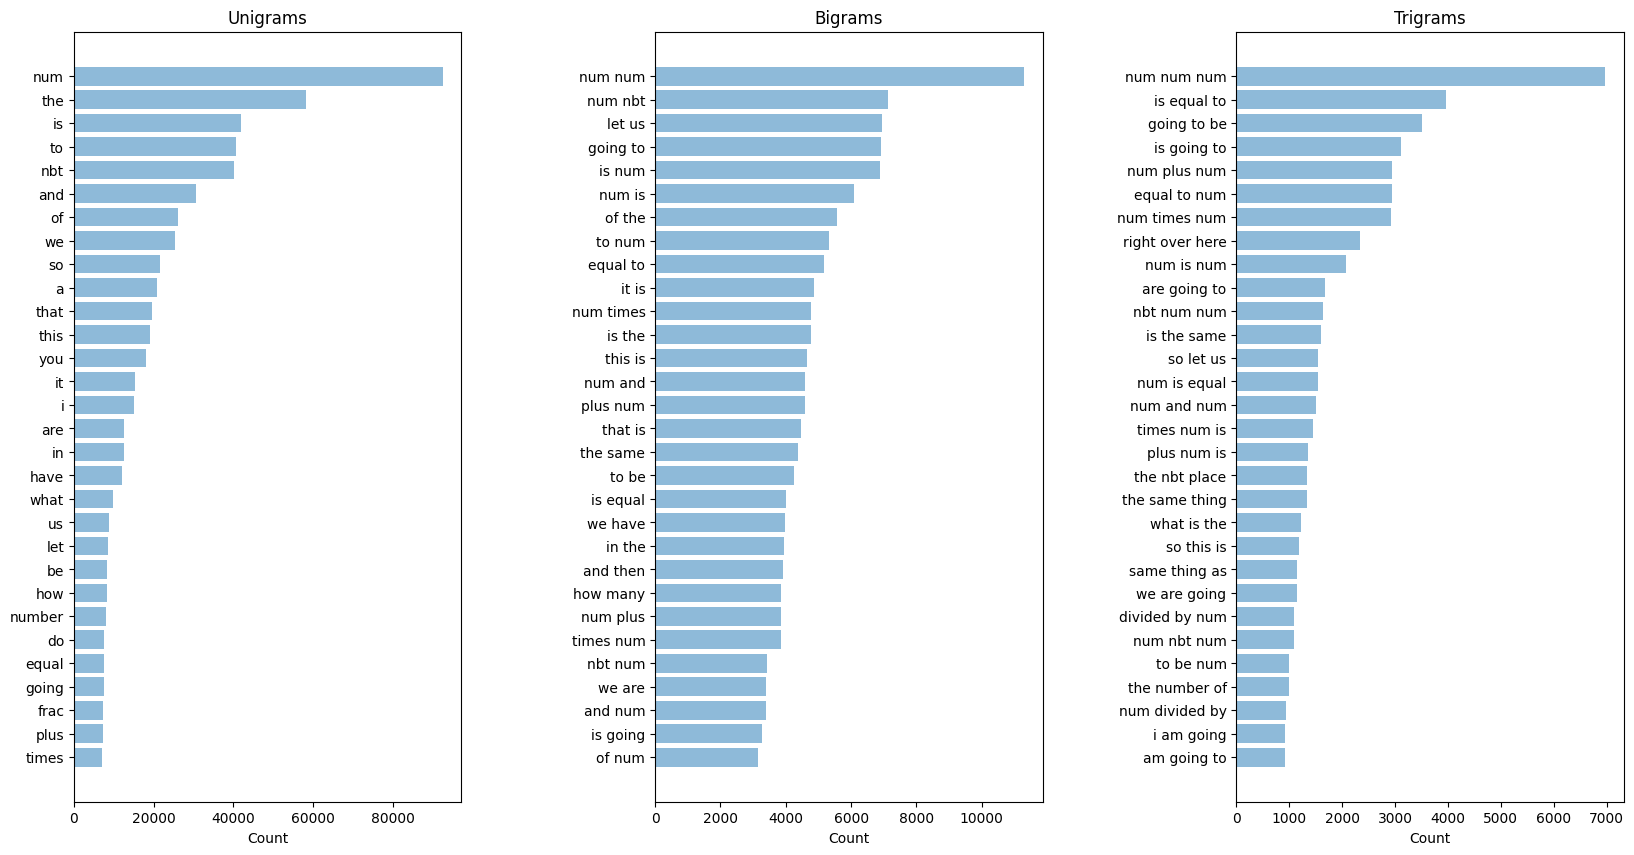

In [ ]:
fig = plt.figure(figsize = (20, 10))
plt.subplots_adjust(wspace=.5)

ax = fig.add_subplot(131)
ax.barh(np.arange(len(unigrams2['words'])), unigrams2['count'], align='center', alpha=.5)
ax.set_title('Unigrams')
plt.yticks(np.arange(len(unigrams2['words'])), unigrams2['words'])
plt.xlabel('Count')

ax2 = fig.add_subplot(132)
ax2.barh(np.arange(len(bigrams2['words'])), bigrams2['count'], align='center', alpha=.5)
ax2.set_title('Bigrams')
plt.yticks(np.arange(len(bigrams2['words'])), bigrams2['words'])
plt.xlabel('Count')

ax3 = fig.add_subplot(133)
ax3.barh(np.arange(len(trigrams2['words'])), trigrams2['count'], align='center', alpha=.5)
ax3.set_title('Trigrams')
plt.yticks(np.arange(len(trigrams2['words'])), trigrams2['words'])
plt.xlabel('Count')

plt.show()

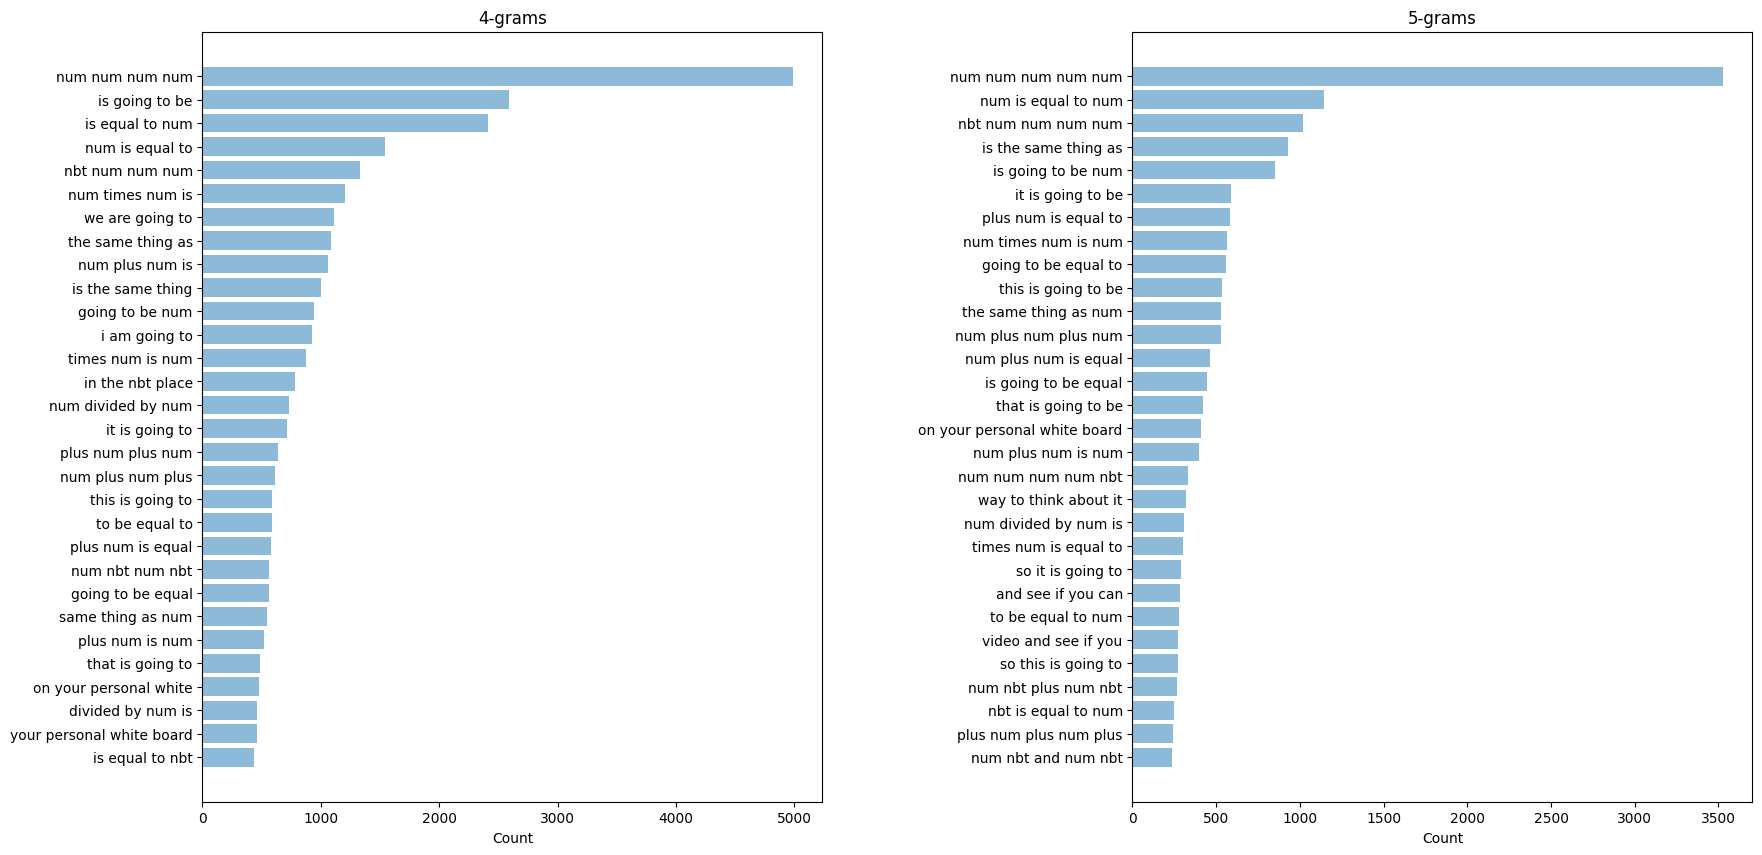

In [ ]:
fig = plt.figure(figsize = (20, 10))
plt.subplots_adjust(wspace=.5)

ax = fig.add_subplot(121)
ax.barh(np.arange(len(fourgrams2['words'])), fourgrams2['count'], align='center', alpha=.5)
ax.set_title('4-grams')
plt.yticks(np.arange(len(fourgrams2['words'])), fourgrams2['words'])
plt.xlabel('Count')

ax2 = fig.add_subplot(122)
ax2.barh(np.arange(len(fivegrams2['words'])), fivegrams2['count'], align='center', alpha=.5)
ax2.set_title('5-grams')
plt.yticks(np.arange(len(fivegrams2['words'])), fivegrams2['words'])
plt.xlabel('Count')
plt.show()

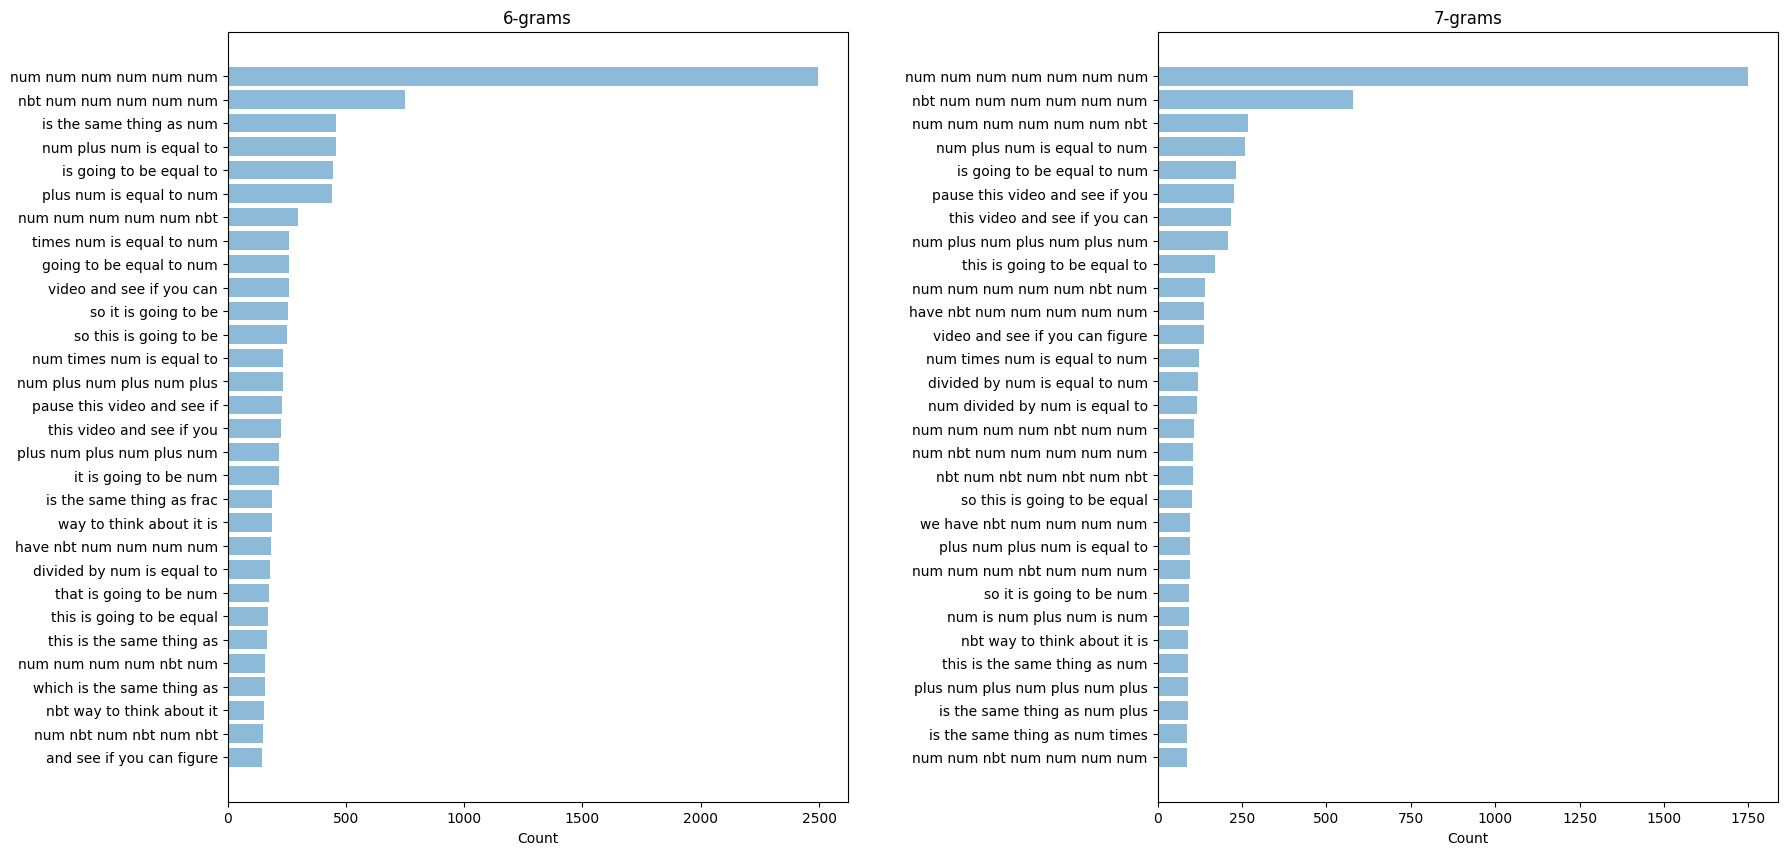

In [ ]:
fig = plt.figure(figsize = (20, 10))
plt.subplots_adjust(wspace=.5)

ax = fig.add_subplot(121)
ax.barh(np.arange(len(sixgrams2['words'])), sixgrams2['count'], align='center', alpha=.5)
ax.set_title('6-grams')
plt.yticks(np.arange(len(sixgrams2['words'])), sixgrams2['words'])
plt.xlabel('Count')

ax2 = fig.add_subplot(122)
ax2.barh(np.arange(len(sevengrams2['words'])), sevengrams2['count'], align='center', alpha=.5)
ax2.set_title('7-grams')
plt.yticks(np.arange(len(sevengrams2['words'])), sevengrams2['words'])
plt.xlabel('Count')
plt.show()

In [ ]:
from google.colab import files
trigrams.to_csv("math_talk_trigrams.csv")
files.download("math_talk_trigrams.csv")

fourgrams.to_csv("math_talk_4grams.csv")
files.download("math_talk_4grams.csv")

fivegrams.to_csv("math_talk_5grams.csv")
files.download("math_talk_5grams.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Next step

1. Break down into students/teachers
2. Compare MathTalk against transcript corpus --> using corpora comparison metric and/or N-gram

In [ ]:
teacher_text2 = teacher_corpus.copy()
teacher_text2['text'] = teacher_text2['text'].apply(lambda x: basic_clean(x))
teacher_text_df = teacher_text2[['text']]

student_text2 = student_corpus.copy()
student_text2['text'] = student_text2['text'].apply(lambda x: basic_clean(x))
student_text_df = student_text2[['text']]

### Teacher Corpus N-gram Visualizations

In [ ]:
teacher_bigrams = getNgrams(teacher_text_df['text'],2)
teacher_trigrams = getNgrams(teacher_text_df['text'],3)
teacher_fourgrams = getNgrams(teacher_text_df['text'],4)
teacher_fivegrams = getNgrams(teacher_text_df['text'],5)
teacher_sixgrams = getNgrams(teacher_text_df['text'],6)

2-gram diversity: 0.09341512355667973
2-gram total grams: 1004195
3-gram diversity: 0.27891005521243756
3-gram total grams: 928414
4-gram diversity: 0.4574166267076599
4-gram total grams: 850872
5-gram diversity: 0.5772063052990105
5-gram total grams: 773635
6-gram diversity: 0.6470231131718368
6-gram total grams: 700077


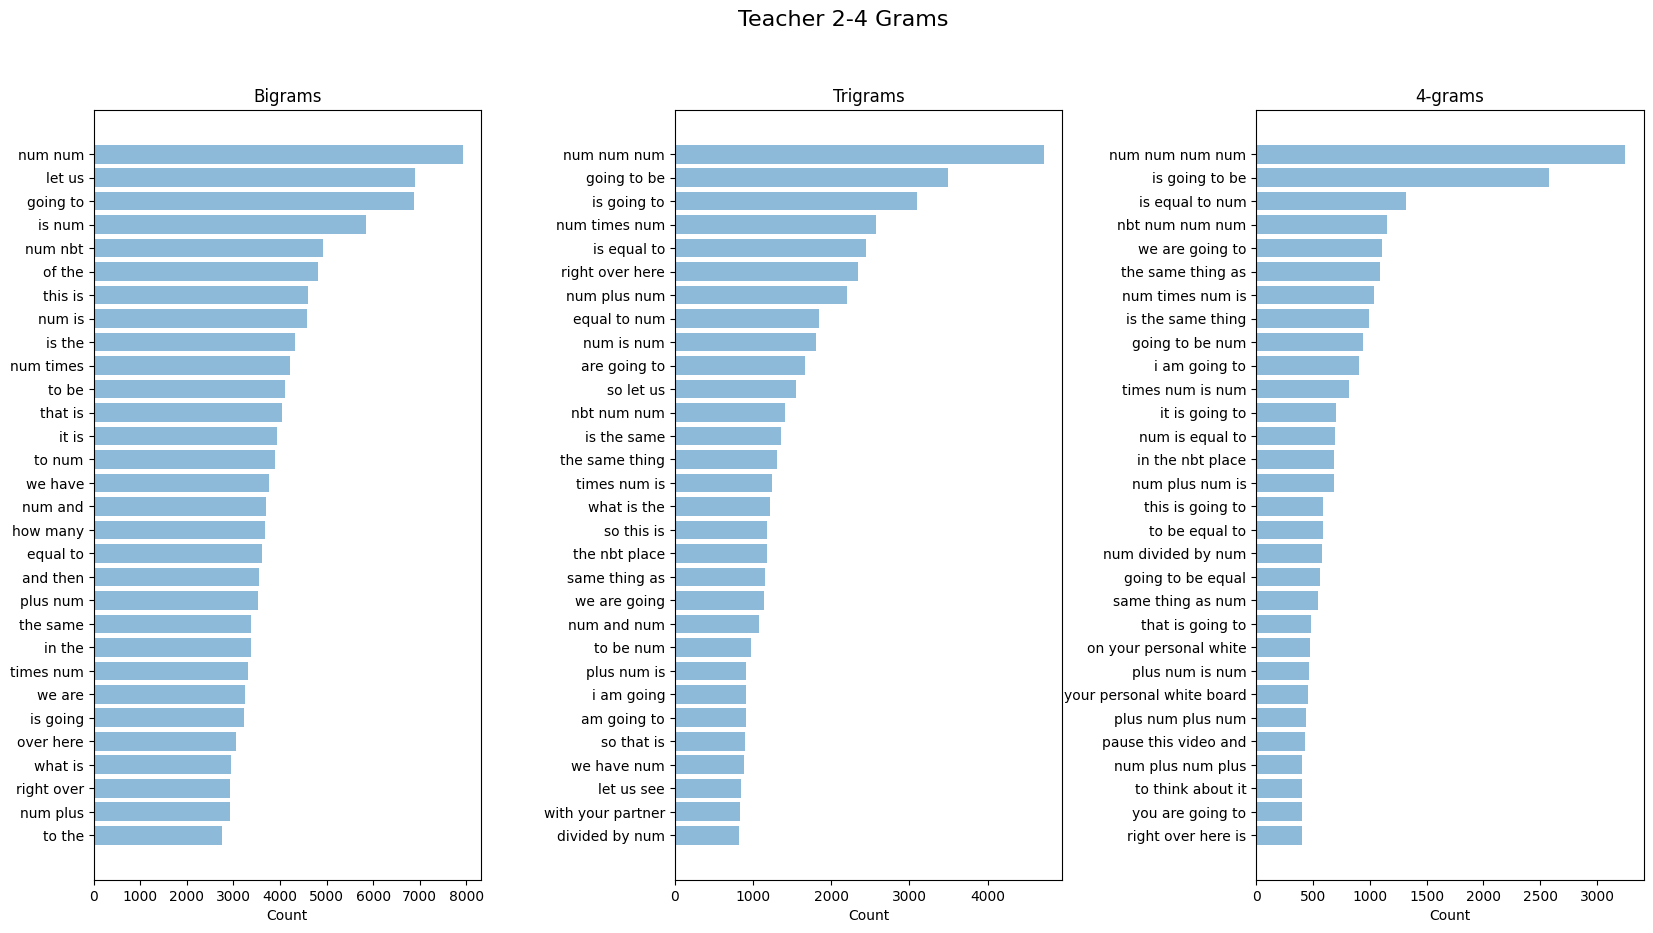

In [ ]:
three_plots(teacher_bigrams, 'Bigrams', teacher_trigrams, 'Trigrams', teacher_fourgrams, '4-grams', 'Teacher 2-4 Grams')

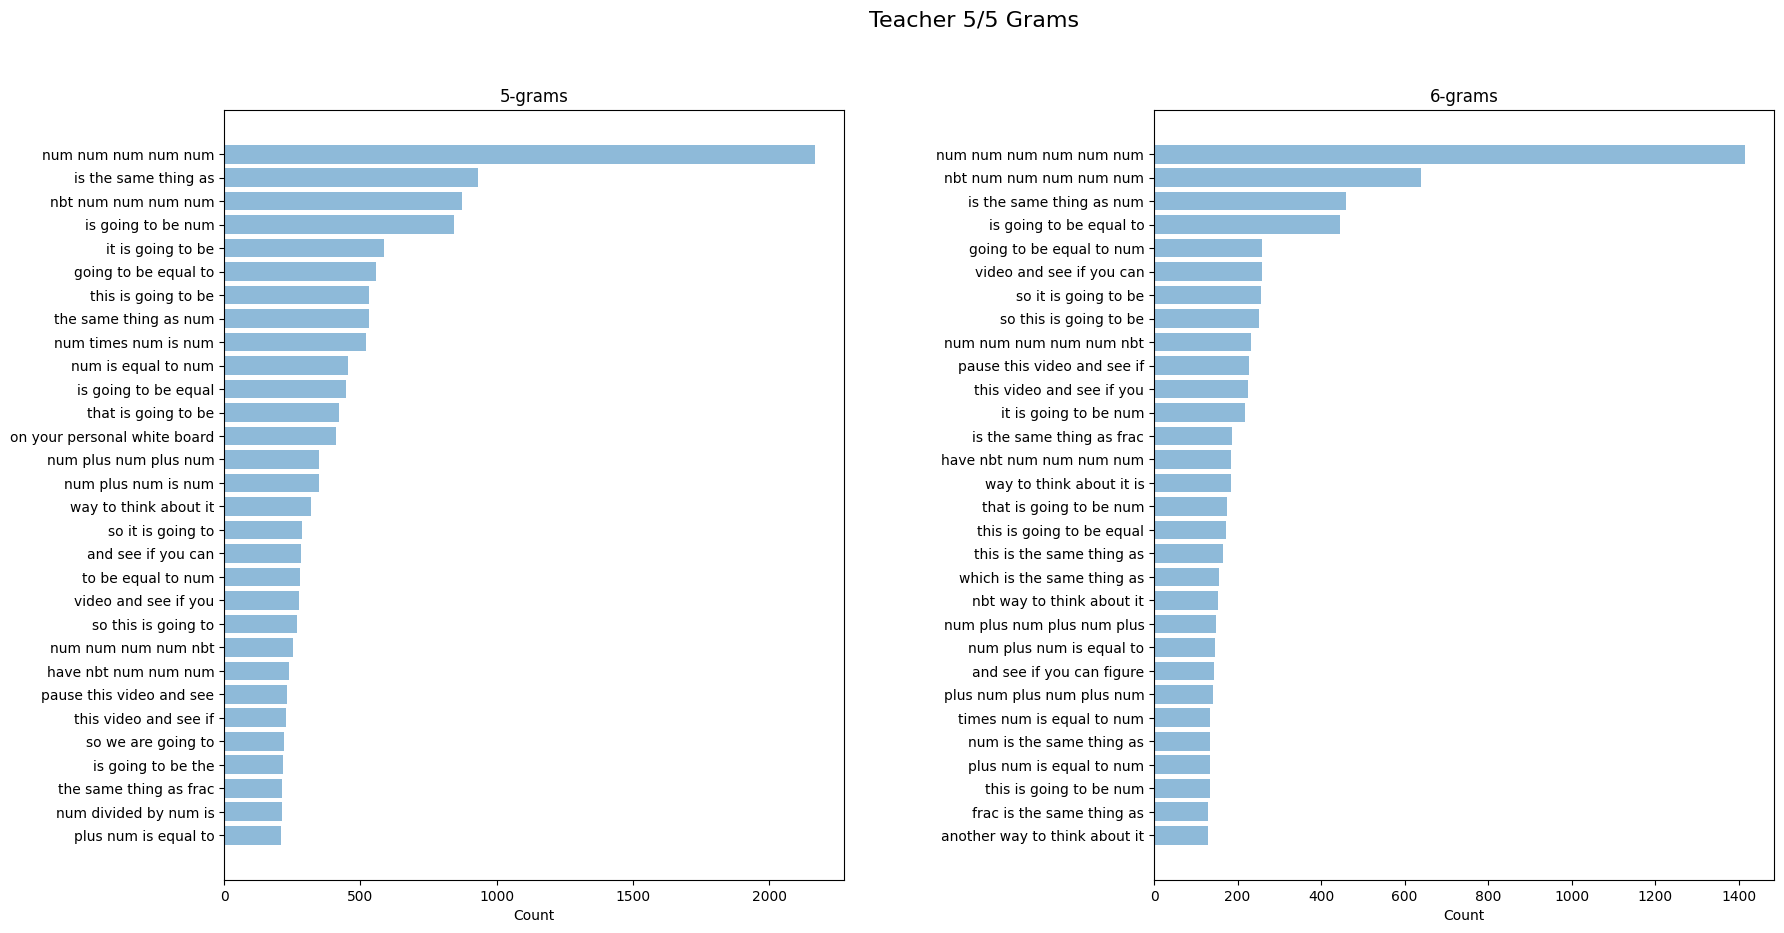

In [ ]:
two_plots(teacher_fivegrams, '5-grams',teacher_sixgrams, '6-grams','Teacher 5/5 Grams')

### Student Corpus N-gram Visualizations

In [ ]:
student_bigrams = getNgrams(student_text_df['text'],2)
student_trigrams = getNgrams(student_text_df['text'],3)
student_fourgrams = getNgrams(student_text_df['text'],4)
student_fivegrams = getNgrams(student_text_df['text'],5)
student_sixgrams = getNgrams(student_text_df['text'],6)

2-gram diversity: 0.1951097012952683
2-gram total grams: 151320
3-gram diversity: 0.4906328233657858
3-gram total grams: 143800
4-gram diversity: 0.7169042321164989
4-gram total grams: 136173
5-gram diversity: 0.8381011431893044
5-gram total grams: 129025
6-gram diversity: 0.8990643351381414
6-gram total grams: 122266


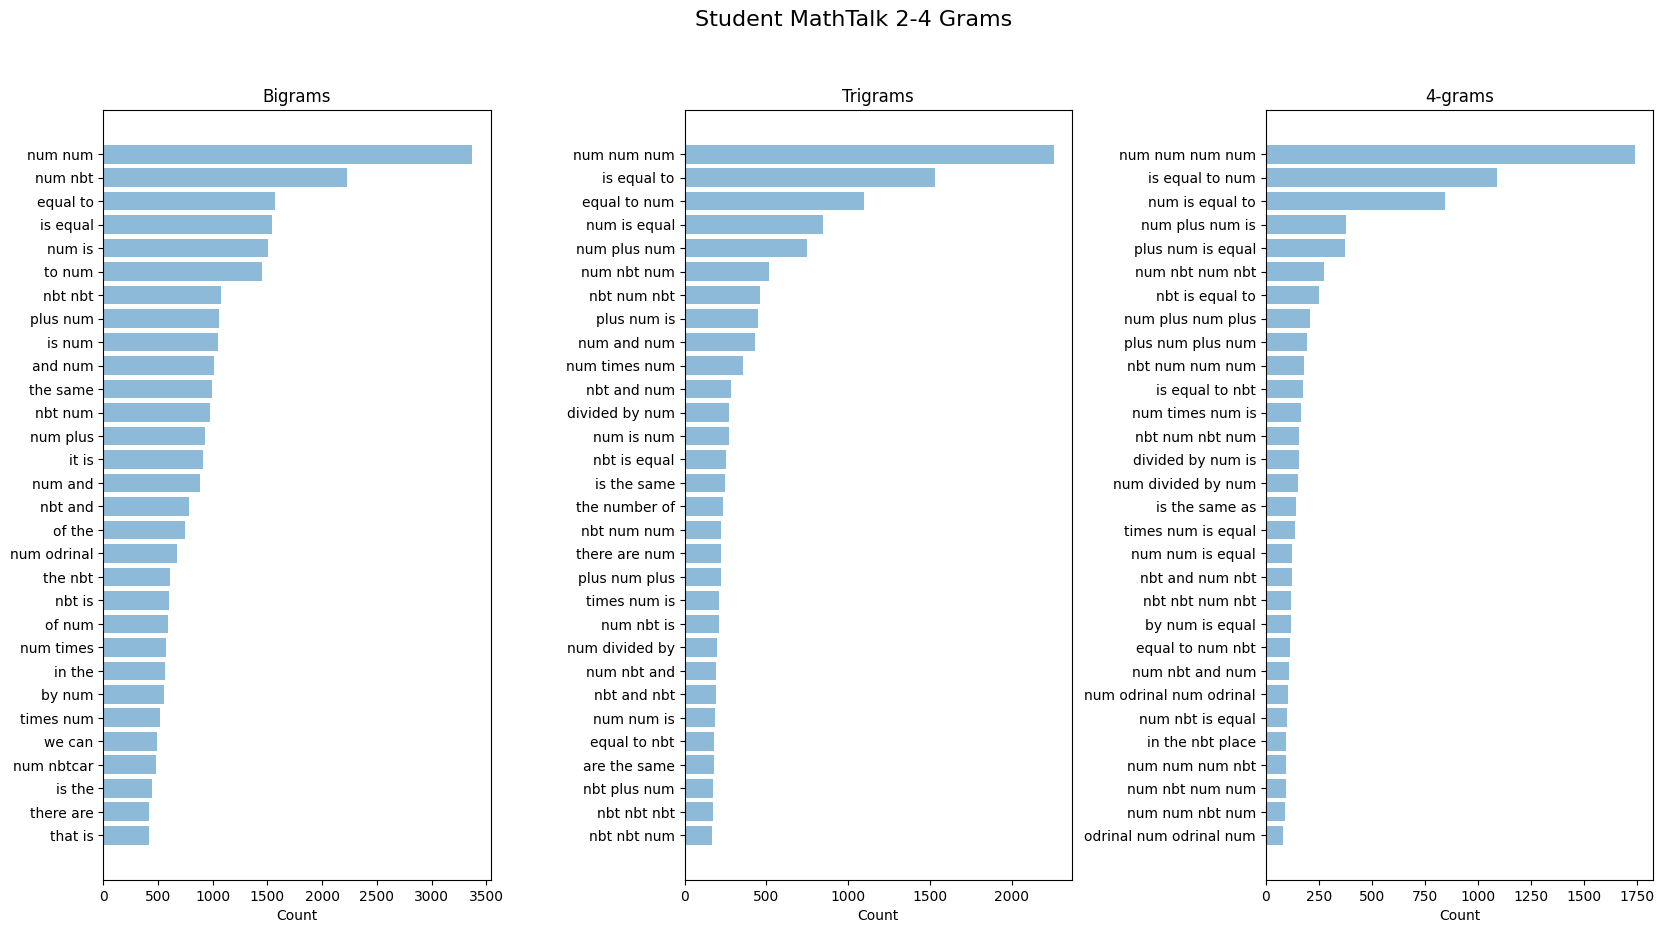

In [ ]:
three_plots(student_bigrams, 'Bigrams', student_trigrams, 'Trigrams', student_fourgrams, '4-grams', 'Student MathTalk 2-4 Grams')

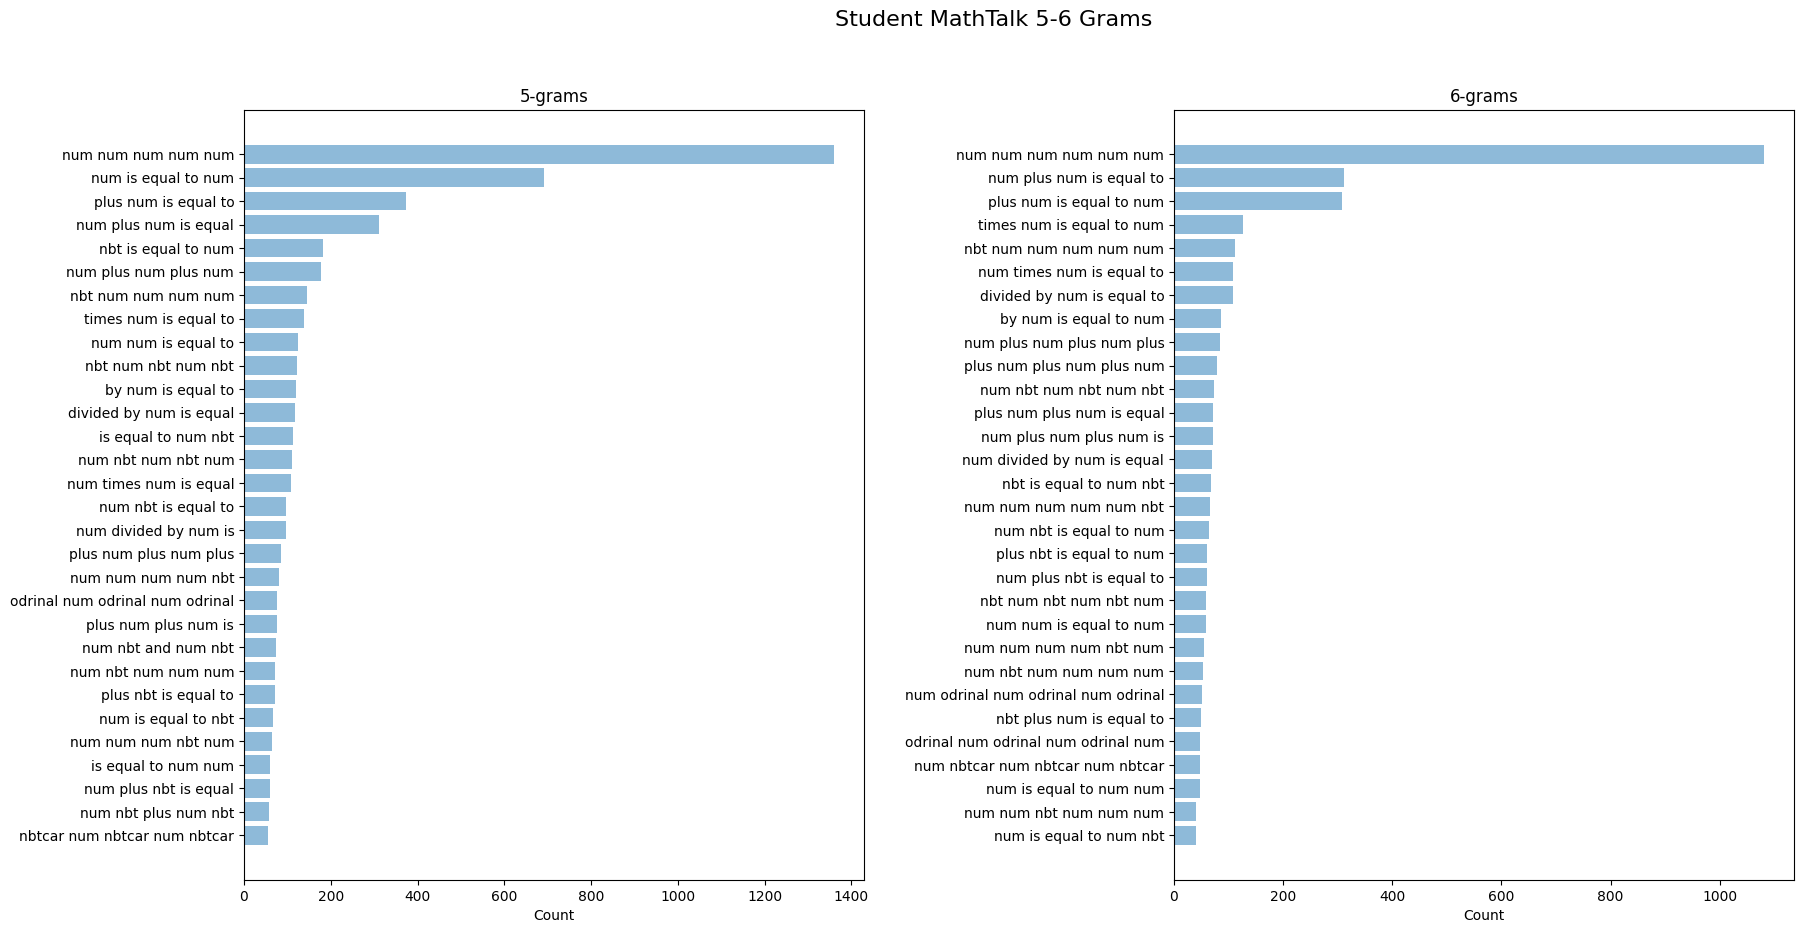

In [ ]:
two_plots(student_fivegrams, '5-grams',student_sixgrams, '6-grams','Student MathTalk 5-6 Grams')

### Process cleaning for NCTE transcript

In [ ]:
ncte_transcript = pd.read_csv(DATA_FOLDER + 'ncte_single_utterances.csv')

In [ ]:
ncte_transcript

,speaker,text,year,OBSID,video_id,cleaned_text,num_words,turn_idx,comb_idx
0,teacher,"Friends, yesterday we started off by working o...",2,2119,706,friends yesterday we started off by working on...,13,0,2119_0
1,student,Yes.,2,2119,706,yes,1,1,2119_1
2,teacher,"And yesterday towards the end of the period, y...",2,2119,706,and yesterday towards the end of the period yo...,38,2,2119_2
3,multiple students,Yes.,2,2119,706,yes,1,3,2119_3
4,teacher,Some of you might be done. If you are finishe...,2,2119,706,some of you might be done if you are finished ...,106,4,2119_4
...,...,...,...,...,...,...,...,...,...
580403,teacher,Can you hit the mouse so we can see. You shoul...,1,315,445,can you hit the mouse so we can see you should...,32,515,315_515
580404,student,I’ll go first.,1,315,445,i ll go first,4,516,315_516
580405,teacher,What do you want to ask her if she has?,1,315,445,what do you want to ask her if she has,10,517,315_517
580406,student,"If she has 5, 1.",1,315,445,if she has 5 1,5,518,315_518


In [ ]:
clean_ncte_transcript = ncte_transcript.copy()

In [ ]:
clean_ncte_transcript['text'] = clean_ncte_transcript['text'].apply(lambda x: process_normalization(str(x)))

In [ ]:
clean_ncte_transcript['text'][440]

'NUM. number NUM i am on -- NUM, NUM, NUM, NUM, NUM, NUM, NUM, NUM, NUM, NUM. number NUM is NUM. ODRINAL to last row, NUM – student g, eyes on your paper -- NUM, NUM, NUM, NUM, NUM, NUM, NUM, NUM, NUM. last row, NUM, NUM, NUM, NUM, NUM, NUM, NUM, NUM, NUM, NUM. if they got NBT you may write NBT percent or minus NUM. anything else, please count up the numbers that they missed twice, mark minus whatever at the top and circle it. student k?'

In [ ]:
clean_ncte_transcript['cleaned_text'][440]

'forty eight number 71 i m on 36 120 110 60 15 49 66 45 56 121 number 80 is 121 second to last row 56 student g eyes on your paper 40 72 32 60 63 88 18 44 27 last row 40 33 36 108 21 45 63 70 96 15 if they got 100 you may write 100 percent or minus 0 anything else please count up the numbers that they missed twice mark minus whatever at the top and circle it student k'

In [ ]:
clean_ncte_transcript[['text']]

,text
0,"friends, yesterday we started off by working o..."
1,yes.
2,"and yesterday towards the end of the period, y..."
3,yes.
4,some of you might be done. if you are finished...
...,...
580403,can you hit the mouse so we can see. you shoul...
580404,i will go first.
580405,what do you want to ask her if she has?
580406,"if she has NUM, NBT."


In [ ]:
clean_ncte_transcript['text'] = clean_ncte_transcript['text'].apply(lambda x: basic_clean(x))

In [ ]:
# save to csv
clean_ncte_transcript.to_csv(DATA_FOLDER + 'clean_ncte_transcript.csv')

In [ ]:
# if i need to reload
clean_ncte_transcript = pd.read_csv(DATA_FOLDER + 'clean_ncte_transcript.csv')

In [ ]:
clean_ncte_transcript['speaker'].unique()

array(['teacher', 'student', 'multiple students', nan], dtype=object)

In [ ]:
# split into student & teacher text
ncte_teacher_text = clean_ncte_transcript[clean_ncte_transcript['speaker'] == 'teacher'][['text']]
ncte_student_text = clean_ncte_transcript[clean_ncte_transcript['speaker'].isin(['student','multiple students'])][['text']]

In [ ]:
print(len(ncte_teacher_text))
print(len(ncte_student_text))

286561
293834


### Corpora comparison -- KL Divergence

- NCTE transcript
  - `ncte_teacher_text`
  - `ncte_student_text`

- MathTalk corpus
  - `teacher_text_df`
  - `student_text_df`

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import numpy as np
from scipy.special import rel_entr

In [ ]:
mathtalk_corpus_teacher = ' '.join(teacher_text_df['text'].tolist())
ncte_corpus_teacher = ' '.join(ncte_teacher_text['text'].tolist())

In [ ]:
mathtalk_teacher_tokens = mathtalk_corpus_teacher.split() # do we need to remove stopwords?
ncte_teacher_tokens = ncte_corpus_teacher.split() # do we need to remove stopwords?

In [ ]:
# Compute the frequency distributions
freq_dist1 = FreqDist(mathtalk_teacher_tokens)
freq_dist2 = FreqDist(ncte_teacher_tokens)

In [ ]:
# since vocabularies are different, need to align them first
# Align the vocabularies
vocab = set(freq_dist1.keys()) | set(freq_dist2.keys())

# Compute the frequency vectors
freq_vec1 = [freq_dist1.get(word, 0) for word in vocab]
freq_vec2 = [freq_dist2.get(word, 0) for word in vocab]

In [ ]:
freq_dist2.keys()

In [ ]:
vocab

In [ ]:
# Compute the KL divergence
def kl_divergence(p, q):
    return np.sum(rel_entr(p, q))

In [ ]:
kl_div = kl_divergence(freq_vec1, freq_vec2)
print(kl_div)

inf


# Notes for Prioritizing and Identifying Math Language

Reviewing standards and curricula prioritized:

Going to clean up our definitions, because I probaby got terms mixed:

Clean out weird text


1. CURR (currency)
2. NBTNF (number base-10 number fraction)
2. (Maybe combine this with former) NBTORD w "place"
4. NF (FRAC. can have nbt in numerator) include "whole",
5. NBTCARD (cardinal NBT)
6. NUMCARD
7. NUMORD
8. LENAREA units for length and area
8. OAMODEL for number line, grouping, array, etc.
9. DEGR degrees
10. MDUNIT measurement and data unit
11. change operations and algebra equivalencies >< = "equal" "less than"
12. OAO operations and algebraic: for mult, div, subtract +
13. SHAPENAME for geom
14. \<UNK\> tokens
15. TIME
16. PEMDAS (or GEMDAS) for order of operations
17. QWHAT for "______" --> maybe even extend to add to, diff, take from
18. QHOWMC how many more, how many less
19.


"regroup vs carry"

## Load full transcript

In [ ]:
df = pd.read_pickle(DATA_FOLDER + "augmented_transcript.pkl")

## Check for Math Lang examples

  0%|          | 0/1658 [00:00<?, ?it/s]

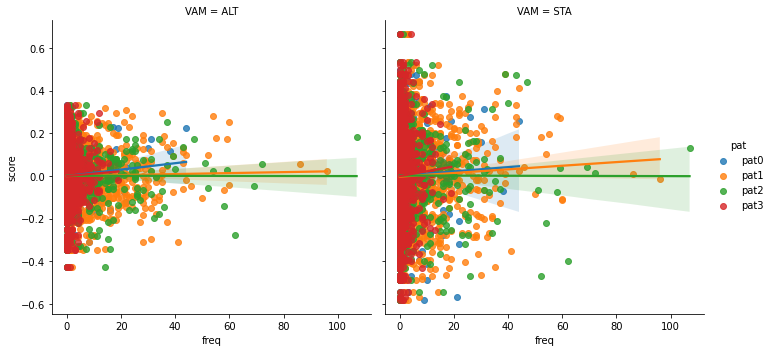

In [ ]:
from tqdm.auto import tqdm
import seaborn as sns
import statsmodels.api as sm
import csv
# import crfm-helm
from copy import deepcopy
from datetime import datetime
import itertools
import matplotlib.pyplot as plt

def compare_specific_feature_examples(df, pats = [], use_cleaned = False, use_lower = True, use_logx = False):
  '''
  Takes in a df of text and two regex pats to compare
  whether there is a difference in performance based on the frequency of the pattern
  '''
  results = {}
  for name, group in tqdm(df.groupby(by = 'OBSID'),total=len(df.groupby(by = 'OBSID'))):
    text = '\n'.join([str(t) for t in group.cleaned_text]) if use_cleaned else '\n'.join(group.text)
    if use_lower: text.lower()
    STA = group.scoreSTA.iloc[0]
    ALT = group.scoreALT.iloc[0]
    # pat1_matches = len(pat1.findall(text))
    # pat2_matches = len(pat2.findall(text))
    results[name] = {'pat'+str(i):len(p.findall(text)) for i, p in enumerate(pats)}
    pat_names = list(results[name].keys())
    # {'pat1':pat1_matches,
                    #  'pat2':pat2_matches,
    results[name].update({
                     'STA':STA,
                     'ALT':ALT,
                     'id_year':group.id_year.iloc[0],
                     })
    results[name]
  results = pd.DataFrame(results).T
  results = results.reset_index().rename(columns ={'index':'OBSID'}).melt(id_vars = ['OBSID','id_year','STA','ALT'], value_vars = pat_names,var_name="pat",value_name='freq').melt(id_vars = ['OBSID','id_year','pat','freq'], value_vars = ['STA','ALT'],var_name="VAM",value_name='score')
  results.pat = results.pat.astype('category')
  results.VAM = results.VAM.astype('category')
  results.score = results.score.astype('float')
  results.freq = results.freq.astype('float')
  sns.lmplot(data=results, x = 'freq', y = 'score', hue='pat', col = 'VAM', logx=use_logx)
  return results


rdf = compare_specific_feature_examples(df, [re.compile('is equal to'), re.compile('equals'), re.compile('equivalen'), re.compile('the same as|the same thing as')], use_cleaned=True)

In [ ]:
# df.dtypes

  0%|          | 0/1658 [00:00<?, ?it/s]

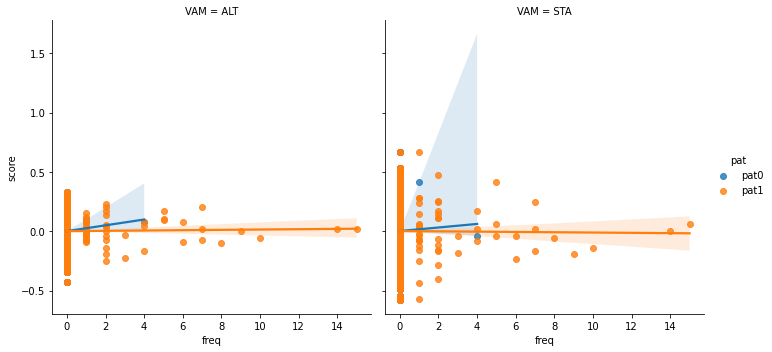

In [ ]:
# rdf = compare_specific_feature_examples(df,[ re.compile('regroup'), re.compile('carr.{1,4} th')])
# compare_specific_feature_examples(df, [re.compile('how many more'), re.compile('how many (?!more)')])
# rdf = compare_specific_feature_examples(df,[ re.compile('remainder'), re.compile('factor'), re.compile('umber lin')], use_lower=True)
rdf = compare_specific_feature_examples(df,[ re.compile('pemdas|pmdas|gemdas|gmdas'), re.compile('order of operations')], use_lower=True)

  0%|          | 0/1658 [00:00<?, ?it/s]

,OBSID,id_year,pat,freq,VAM,score
0,3,11024_11,pat0,4.0,STA,-0.098283
1,4,11054_11,pat0,9.0,STA,0.421757
2,5,11011_11,pat0,0.0,STA,-0.546208
3,7,11050_11,pat0,0.0,STA,0.435624
4,8,11022_11,pat0,0.0,STA,0.023429
...,...,...,...,...,...,...
9943,4758,12035_13,pat2,0.0,ALT,NaN
9944,4759,13092_13,pat2,0.0,ALT,-0.200230
9945,4760,12014_13,pat2,0.0,ALT,-0.100643
9946,4762,12039_13,pat2,0.0,ALT,NaN


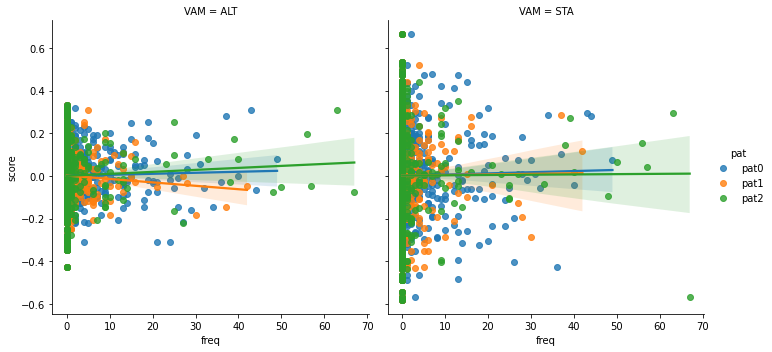

In [ ]:
# compare_specific_feature_examples(df, [re.compile('how many more'), re.compile('how many (?!more)')])
compare_specific_feature_examples(df, [re.compile('equation'), re.compile('umber sentenc'),re.compile('xpression')])

  0%|          | 0/1658 [00:00<?, ?it/s]

,OBSID,id_year,pat,freq,VAM,score
0,3,11024_11,pat1,0.0,STA,-0.098283
1,4,11054_11,pat1,0.0,STA,0.421757
2,5,11011_11,pat1,0.0,STA,-0.546208
3,7,11050_11,pat1,4.0,STA,0.435624
4,8,11022_11,pat1,0.0,STA,0.023429
...,...,...,...,...,...,...
6627,4758,12035_13,pat2,0.0,ALT,NaN
6628,4759,13092_13,pat2,0.0,ALT,-0.200230
6629,4760,12014_13,pat2,0.0,ALT,-0.100643
6630,4762,12039_13,pat2,0.0,ALT,NaN


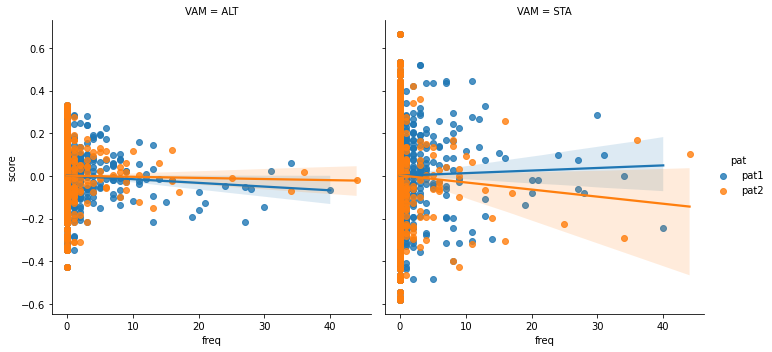

In [ ]:
compare_specific_feature_examples(df,[ re.compile('word problem'), re.compile('story problem')])

  0%|          | 0/1658 [00:00<?, ?it/s]

,OBSID,id_year,pat,freq,VAM,score
0,3,11024_11,pat0,114.0,STA,-0.098283
1,4,11054_11,pat0,228.0,STA,0.421757
2,5,11011_11,pat0,4.0,STA,-0.546208
3,7,11050_11,pat0,13.0,STA,0.435624
4,8,11022_11,pat0,158.0,STA,0.023429
...,...,...,...,...,...,...
13259,4758,12035_13,pat3,6.0,ALT,NaN
13260,4759,13092_13,pat3,10.0,ALT,-0.200230
13261,4760,12014_13,pat3,36.0,ALT,-0.100643
13262,4762,12039_13,pat3,0.0,ALT,NaN


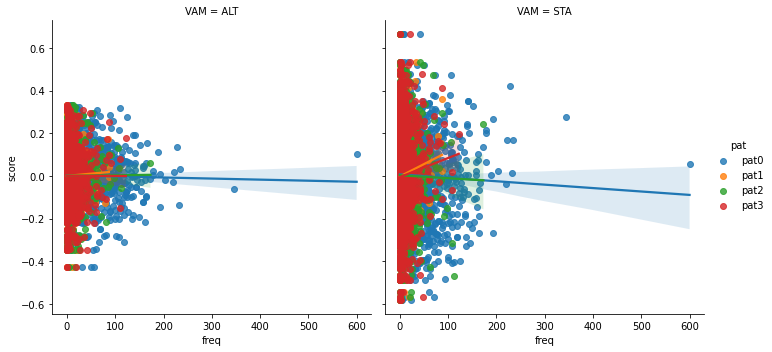

In [ ]:
compare_specific_feature_examples(df,[ re.compile("times|multipl"), re.compile('minus|subtract '),re.compile('divide'),re.compile('plus ')], use_lower = True)

  0%|          | 0/1658 [00:00<?, ?it/s]

,OBSID,id_year,pat,freq,VAM,score
0,3,11024_11,pat0,110.0,STA,-0.098283
1,4,11054_11,pat0,218.0,STA,0.421757
2,5,11011_11,pat0,1.0,STA,-0.546208
3,7,11050_11,pat0,3.0,STA,0.435624
4,8,11022_11,pat0,151.0,STA,0.023429
...,...,...,...,...,...,...
6627,4758,12035_13,pat1,12.0,ALT,NaN
6628,4759,13092_13,pat1,7.0,ALT,-0.200230
6629,4760,12014_13,pat1,15.0,ALT,-0.100643
6630,4762,12039_13,pat1,3.0,ALT,NaN


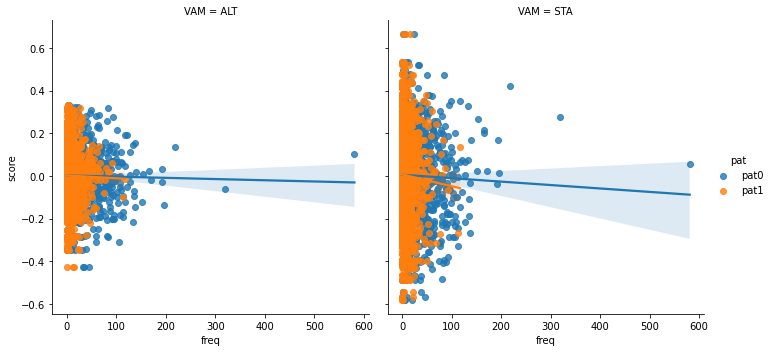

In [ ]:
compare_specific_feature_examples(df,[ re.compile("times"), re.compile('multipl')], use_lower = True)

  0%|          | 0/1658 [00:00<?, ?it/s]

,OBSID,id_year,pat,freq,VAM,score
0,3,11024_11,pat0,0.0,STA,-0.098283
1,4,11054_11,pat0,2.0,STA,0.421757
2,5,11011_11,pat0,0.0,STA,-0.546208
3,7,11050_11,pat0,0.0,STA,0.435624
4,8,11022_11,pat0,1.0,STA,0.023429
...,...,...,...,...,...,...
13259,4758,12035_13,pat3,0.0,ALT,NaN
13260,4759,13092_13,pat3,0.0,ALT,-0.200230
13261,4760,12014_13,pat3,0.0,ALT,-0.100643
13262,4762,12039_13,pat3,0.0,ALT,NaN


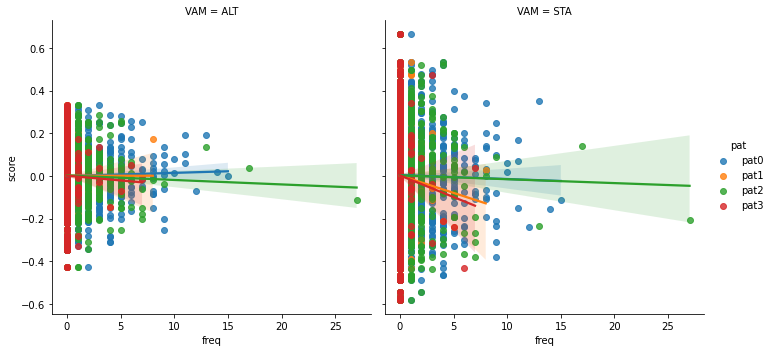

In [ ]:
compare_specific_feature_examples(df,[ re.compile("on top|on the top"), re.compile('in the numerat'),re.compile('on bottom|on the bottom'),re.compile('in the denomin')])

# Build Use NLTK to tokenize Gensim Corpora

#### Prepare Corpus using Math Corpus to compare transcrtips

In [ ]:
!pip install annoy
import annoy
import nltk
import gensim
import seaborn as sns
from gensim import corpora
from gensim.matutils import kullback_leibler, jensen_shannon
from nltk.tokenize import word_tokenize
import gensim
from gensim import corpora
from gensim.matutils import kullback_leibler
import gc
import numpy as np
from scipy.stats import entropy
nltk.download('punkt')
CORP_FOLDER = DATA_FOLDER + 'corpora_files/'
from gensim.test.utils import datapath
from gensim import utils
from gensim.models import LogEntropyModel
from gensim.test.utils import common_texts
from gensim.corpora import Dictionary, MmCorpus
from gensim.similarities import Similarity
from gensim.models import LsiModel, LogEntropyModel
import gensim.models
## Clean corpus df
cdf = pd.read_csv(DATA_FOLDER + 'clean_corpus1.csv')
# cdf = cdf.drop(columns = ['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1'])
cdf = cdf[cdf.text.notnull()]

## Transcript df
tdf = pd.read_csv(DATA_FOLDER + 'clean_ncte_transcript.csv')
tdf = tdf.drop(columns = "Unnamed: 0")
tdf = tdf[tdf.cleaned_text.notnull()]
tdf = tdf[~tdf.OBSID.isin([4263,2065])]

#### Make a basic dictionary and corpus

In [ ]:
LOGS = False  # Set to True if you want to see progress in logs.
if LOGS:
    import logging
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
from gensim.test.utils import datapath
from gensim import utils
from gensim.models import LogEntropyModel
from gensim.test.utils import common_texts
from gensim.corpora import Dictionary, MmCorpus
from gensim.similarities import Similarity
from gensim.models import LsiModel, LogEntropyModel

class MyCorpus:
    """An iterator that yields sentences (lists of str)."""
    def __iter__(self):
        # corpus_path = datapath('lee_background.cor')
        for line in cdf.text:
            # assume there's one document per line, tokens separated by whitespace
            yield utils.simple_preprocess(line)

import gensim.models

sentences = MyCorpus()
model = gensim.models.Word2Vec(sentences=sentences)
wv = model.wv
dct = Dictionary(sentences)  # fit dictionary
corpus = [dct.doc2bow(row) for row in sentences]
logmod = gensim.models.LogEntropyModel(corpus, dct)
# logent_corpus = MmCorpus(logmod[corpus])
math_transformed = logmod[corpus]
lsi_transformation = LsiModel(math_transformed, id2word=dct)
index = Similarity(corpus = lsi_transformation[math_transformed], num_features=400, output_prefix="shard")

#### This code crashes when trying to index all the transcripts on our corpus

In [ ]:
class Corp:
  """An iterator that yields sentences (lists of str)."""
  def __init__(self, text):
    self.text = text
  def __iter__(self):
    # corpus_path = datapath('lee_background.cor')
    for line in self.text:
        # assume there's one document per line, tokens separated by whitespace
        yield utils.simple_preprocess(line)

OBSID_corpus = {}
# OBSID_log_transformed = {}
OBSID_lsi ={}

for name, group in tdf.groupby(by='OBSID'):
  # sents =
  OBSID_corpus[name] = [dct.doc2bow(row) for row in Corp(group.text)]
  # OBSID_log_transformed[name] =
  OBSID_lsi[name] = lsi_transformation[logmod[OBSID_corpus[name]]]
  # OBSID_sim[name] = index[OBSID_lsi[name]]


In [ ]:
gc.collect()

122

In [ ]:
for name, group in tdf.groupby(by='OBSID'):
  OBSID_sim[name] = index[OBSID_lsi[name]]

/usr/local/lib/python3.8/dist-packages/gensim/similarities/docsim.py:518: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = numpy.hstack(shard_results)


In [ ]:
OBSID_sim = {}
OBSID_sims = [OBSID_corpus,OBSID_lsi,OBSID_sim]
with open(DATA_FOLDER + 'corpus_sims_list.pkl', 'wb') as f:
  pickle.dump(OBSID_sims, f)

In [ ]:
OBSID_math_sim_idx = {}

for name, group in tdf.groupby(by='OBSID'):
  OBSID_math_sim_idx[name] = np.argmax(OBSID_sim[name],axis=1)

In [ ]:
OBSID_sim[name]

#### Workspace

In [ ]:
import logging, sys, pprint

sims_to_query = index[lsi_transformation[logent_transformation[dictionary.doc2bow(tokenize_func(query))]]]

index[OBSID_lsi[73]].shape

In [ ]:
np.argmax(index[OBSID_lsi[73]],axis = 1)

array([64277,     0, 30774, 30774, 22512, 69192, 24515, 31639, 74093,
       70173, 58731, 31704, 14621, 12957, 67136, 39526, 30774, 30774,
       67435, 81505, 59216, 67325,  2640, 59209,     0, 27078, 69135,
       72098, 77026, 70963, 80274, 67390,  5992, 50561, 80338,  6864,
       36949, 24018, 52988, 12734, 71944, 72033,  2851, 11313, 75995,
        2640, 37803, 50773,  3755,     0, 29189, 40432, 32784, 20462,
       23032, 17023, 81446, 40362, 50546, 31801,     0, 58674, 80338,
       21813, 74894, 10678,     0, 79942,     0, 56866, 81360, 80292,
       40147,     0,     0, 53356, 25837, 69435, 40147, 66278, 46020,
       82250,     0,  1127, 40274, 68127, 24000, 34073,  5562, 30039,
       63105,     0,  9972, 17023, 42261, 15344, 40147,     0, 21857,
       74664, 45186, 74866, 57584, 12548, 45188, 57955, 75404, 66767,
         779, 45254, 41571, 80733, 45994, 11190, 29366, 29882, 58836,
       49122, 36961,     0,  7055,     0, 73875,     0, 67716,  2640,
       12666, 63146,

In [ ]:
similar_docs = np.argmax(index[OBSID_lsi[73]],axis = 1)

/usr/local/lib/python3.8/dist-packages/gensim/similarities/docsim.py:518: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = numpy.hstack(shard_results)


In [ ]:
pd.Series(similar_docs).value_counts()

0        37
2640     16
17023     5
58836     5
40147     4
         ..
57955     1
75404     1
66767     1
779       1
67525     1
Length: 236, dtype: int64

In [ ]:
cdf.iloc[0,:]

grade                                    K
domain                                  MD
cluster                                NaN
standard                              K.MD
speaker                            teacher
text        what kinds of toys do you see?
source                        talking_math
est_tok                                 12
Name: 0, dtype: object

In [ ]:
simdf = cdf.iloc[similar_docs,:]

In [ ]:
simdf.domain.value_counts()

MD     86
NBT    73
OA     27
G      17
NF     17
EE     16
SP     13
NS      9
CC      2
RP      1
Name: domain, dtype: int64

In [ ]:
tdf[tdf.OBSID == 73].shape

(325, 9)

In [ ]:
len(cdf)

83128

In [ ]:
kl_divergence = entropy(
    np.transpose(math_corpus_vector),
    np.transpose(np.array([np.array(doc) for doc in OBSID_corpus[703]])),
    base=2
)


vec1 = math_corpus_vector
vec2 = np.transpose(np.array([np.array(doc) for doc in OBSID_corpus[703]]))

kl = gensim.matutils.kullback_leibler(vec1, vec2, num_features=None)
js = gensim.matutils.jensen_shannon(vec1, vec2, num_features=None)
kl

In [ ]:
gen_docs = [[w.lower() for w in word_tokenize(text)] for text in cdf.text]
dictionary = gensim.corpora.Dictionary(gen_docs)
corpus = [dictionary.doc2bow(gen_doc) for gen_doc in gen_docs]
len(corpus)

In [ ]:
df.OBSID.nunique()

1660

# Basic Corpus using LSI

In [ ]:
import nltk
from nltk.corpus import stopwords
from gensim import corpora, models, similarities
from tqdm.auto import tqdm
nltk.download('stopwords')
import datetime
import time
from __future__ import division

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
start_time = time.time()

datetime.datetime.fromtimestamp(start_time).strftime('%H:%M:%S')

'15:48:30'

In [ ]:
# Tokenize and preprocess the corpus

domains = []
grade_domains = []
standards = []
corpus_by_standard = []
corpus_by_grade_domain = []
corpus_by_domain = []

for standard, group in cdf.groupby('standard'):
  if standard:
    corpus_by_standard.append("\n".join(group.text))
    standards.append(standard)

for gd, group in cdf.groupby(['grade','domain']):
  grade, domain = gd
  # print(grade)
  if pd.notnull(domain) & pd.notnull(grade) & (len(group) > 5):
    corpus_by_grade_domain.append("\n".join(group.text))
    grade_domains.append("_".join([str(x) for x in gd]))

for domain, group in cdf.groupby('domain'):
  if domain:
    corpus_by_domain.append("\n".join(group.text))
    domains.append(domain)

math_corpora = {"standard":{'corpus':corpus_by_standard, 'labels':standards},
           "grade_domain":{'corpus':corpus_by_grade_domain, 'labels':grade_domains},
           "domain":{'corpus':corpus_by_domain, 'labels':domains}}


stop_words = set(stopwords.words('english'))
# corpus = ["\n".join(cdf.text), "\n".join(tdf.cleaned_text)]

transcripts = [[word for word in document.lower().split() if word not in stop_words and word != '']
                    for document in ["\n".join(g.text) for ob, g in tdf.groupby('OBSID')]]


start_time = time.time()
for k in tqdm(math_corpora.keys(), total = len(math_corpora.keys())):
  loop_time = time.time()
  math_corpora[k]['texts'] = [[word for word in document.lower().split() if word not in stop_words]
          for document in math_corpora[k]['corpus']]
  math_corpora[k]['dictionary'] = corpora.Dictionary(math_corpora[k]['texts'])
  math_corpora[k]['corpus_gensim'] = [math_corpora[k]['dictionary'].doc2bow(text) for text in math_corpora[k]['texts']]
  t1 = time.time()
  print(f'{k}: gensim_corpus-- {t1 - loop_time}')
  math_corpora[k]['lsi_model'] = models.LsiModel(math_corpora[k]['corpus_gensim'], id2word=math_corpora[k]['dictionary'], num_topics=len(math_corpora[k]['labels']))
  t2 = time.time()
  print(f'{k}: lsi w {len(math_corpora[k]["labels"])}labels-- {t2- t1}')
  math_corpora[k]['corpus_lsi'] = math_corpora[k]['lsi_model'][math_corpora[k]['corpus_gensim']]
  t3 = time.time()
  print(f'{k}: corpus lsi-- {t3- t2}')
  math_corpora[k]['transcript_gensim'] = [math_corpora[k]['dictionary'].doc2bow(text) for text in transcripts]
  t4 = time.time()
  print(f'{k}: trans lsi-- {t4- t3}')
  math_corpora[k]['transcript_lsi'] = math_corpora[k]['lsi_model'][math_corpora[k]['transcript_gensim']]
  t5 = time.time()
  print(f'{k}: trans lsi-- {t5- t4}')
  math_corpora[k]['index'] = similarities.MatrixSimilarity(math_corpora[k]['corpus_lsi'])
  t6 = time.time()
  print(f'{k}: index lsi-- {t6- t5}')
  math_corpora[k]['similarities'] = math_corpora[k]['index'][math_corpora[k]['transcript_lsi']]
  print(f'{k}: index lsi-- {time.time()- t5}')


# f"Start time: {datetime.datetime.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S')}"


  0%|          | 0/3 [00:00<?, ?it/s]

standard: gensim_corpus-- 1.0099093914031982
standard: lsi w 445labels-- 8.523329734802246
standard: corpus lsi-- 0.00015544891357421875


standard: trans lsi-- 1.8474175930023193
standard: trans lsi-- 0.0001747608184814453
standard: index lsi-- 0.5465672016143799
standard: index lsi-- 3.0580265522003174
grade_domain: gensim_corpus-- 1.1913845539093018
grade_domain: lsi w 60labels-- 1.0726609230041504
grade_domain: corpus lsi-- 0.0009593963623046875


grade_domain: trans lsi-- 1.325838565826416
grade_domain: trans lsi-- 0.0009970664978027344
grade_domain: index lsi-- 0.05380606651306152
grade_domain: index lsi-- 0.44109439849853516
domain: gensim_corpus-- 0.7355427742004395
domain: lsi w 15labels-- 0.6694002151489258
domain: corpus lsi-- 0.0010695457458496094


domain: trans lsi-- 1.9105010032653809
domain: trans lsi-- 0.0003216266632080078
domain: index lsi-- 0.049930572509765625
domain: index lsi-- 0.4832477569580078


In [ ]:
math_corpora['domain']['similarities'].shape

(1658, 15)

In [ ]:
obs = []
dom = []
gd = []
st = []
for i, (ob, g) in enumerate(tdf.groupby('OBSID')):
  # print(f'{i}:{ob}')
  obs.append(ob)
  dom.append(domains[np.argmax(math_corpora['domain']['similarities'][i])])
  st.append(standards[np.argmax(math_corpora['standard']['similarities'][i])])
  gd.append(grade_domains[np.argmax(math_corpora['grade_domain']['similarities'][i])])
  # 'similarities':math_corpora['standard']['similarities']

pd.DataFrame([dom, gd, st], index = obs)

In [ ]:
obsdf = pd.DataFrame({'domain':dom, 'grade_domain':gd, 'standard':st}, index = obs)
obsdf

,domain,grade_domain,standard
3,MD,4_MD,4.MD.A.2
4,MD,4_MD,4.NBT.B.5
5,MD,4_MD,4.MD.A.1
7,G,4_MD,5.NF.B.7b
8,MD,4_MD,4.NBT.B.5
...,...,...,...
4758,MD,4_MD,4.MD.A.2
4759,MD,4_MD,4.MD.A.2
4760,MD,4_MD,4.MD.A.2
4762,G,4_MD,2.G.A.1


In [ ]:
obsdf = pd.concat([obsdf,
                   obsdf.standard.str.split(".",expand=True).rename(columns= {0:'grade_st',1:'domain_st',2:'cluster',3:'standard_number'}),
                   obsdf.grade_domain.str.split("_",expand=True).rename(columns= {0:'grade_gd',1:'domain_gd'})],axis=1)

obsdf

,domain,grade_domain,standard,grade_st,domain_st,cluster,standard_number,grade_gd,domain_gd
3,MD,4_MD,4.MD.A.2,4,MD,A,2,4,MD
4,MD,4_MD,4.NBT.B.5,4,NBT,B,5,4,MD
5,MD,4_MD,4.MD.A.1,4,MD,A,1,4,MD
7,G,4_MD,5.NF.B.7b,5,NF,B,7b,4,MD
8,MD,4_MD,4.NBT.B.5,4,NBT,B,5,4,MD
...,...,...,...,...,...,...,...,...,...
4758,MD,4_MD,4.MD.A.2,4,MD,A,2,4,MD
4759,MD,4_MD,4.MD.A.2,4,MD,A,2,4,MD
4760,MD,4_MD,4.MD.A.2,4,MD,A,2,4,MD
4762,G,4_MD,2.G.A.1,2,G,A,1,4,MD


In [ ]:
odf = pd.read_csv(DATA_FOLDER + 'OBSID_level.csv')

In [ ]:
odf = pd.merge(odf,obsdf,left_on='OBSID',right_index = True, how='inner')
odf

,Unnamed: 0,speaker,text,year,OBSID,video_id,cleaned_text,num_words,turn_idx,comb_idx,...,s_math_slope,domain,grade_domain,standard,grade_st,domain_st,cluster,standard_number,grade_gd,domain_gd
0,415457,teacher,"Okay. Math should be out. Everything else, p...",1,3,329,okay math should be out everything else please...,197,0,3_0,...,-0.001363,MD,4_MD,4.MD.A.2,4,MD,A,2,4,MD
1,330550,teacher,"Red. It’s red, okay. Okay. Boys and girls, ...",1,4,327,red it s red okay okay boys and girls you can ...,116,0,4_0,...,-0.000470,MD,4_MD,4.NBT.B.5,4,NBT,B,5,4,MD
2,358545,teacher,Okay. This afternoon we’re going to be doing ...,1,5,326,okay this afternoon we re going to be doing a ...,12,0,5_0,...,-0.002652,MD,4_MD,4.MD.A.1,4,MD,A,1,4,MD
3,369651,teacher,"Okay. Okay, good afternoon boys and girls.",1,7,341,okay okay good afternoon boys and girls,7,0,7_0,...,-0.017357,G,4_MD,5.NF.B.7b,5,NF,B,7b,4,MD
4,505207,teacher,Perfect. Raise your what? I put your bag out...,1,8,350,perfect raise your what i put your bag outside...,48,0,8_0,...,-0.006111,MD,4_MD,4.NBT.B.5,4,NBT,B,5,4,MD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1653,256508,teacher,[Side Conversation] Take out your math notebo...,3,4758,428,side conversation take out your math notebooks...,22,0,4758_0,...,0.006617,MD,4_MD,4.MD.A.2,4,MD,A,2,4,MD
1654,289709,multiple students,[Crosstalk].,3,4759,537,crosstalk,1,0,4759_0,...,-0.000766,MD,4_MD,4.MD.A.2,4,MD,A,2,4,MD
1655,257312,teacher,Okay.,3,4760,441,okay,1,0,4760_0,...,-0.000360,MD,4_MD,4.MD.A.2,4,MD,A,2,4,MD
1656,214567,teacher,"Okay boys and girls, so you’re Uniform Benchma...",3,4762,444,okay boys and girls so you re uniform benchmar...,196,0,4762_0,...,-0.000638,G,4_MD,2.G.A.1,2,G,A,1,4,MD


In [ ]:
cdf.domain.nunique()

15

In [ ]:
odf[odf.grade_st =='None'] = np.nan
odf.grade_st = odf.grade_st.astype(float)
odf.grade_gd = odf.grade_gd.astype(float)

In [ ]:
math_corpora['grade_domain']['lsi_model'].print_topics(num_topics=50, num_words=15)

[(0,
  '0.785*"num" + 0.370*"nbt" + 0.233*"num," + 0.184*"num." + 0.117*"let" + 0.111*"us" + 0.105*"going" + 0.103*"nbt," + 0.100*"times" + 0.099*"plus" + 0.099*"nbt." + 0.088*"equal" + 0.080*"number" + 0.071*"could" + 0.057*"right"'),
 (1,
  '0.570*"nbt" + -0.354*"frac" + -0.225*"equal" + 0.206*"nbt." + -0.200*"going" + -0.195*"frac." + -0.163*"odrinal" + -0.158*"frac," + -0.152*"could" + -0.147*"num," + -0.139*"right" + -0.131*"let" + 0.111*"nbt," + -0.105*"times" + -0.105*"would"'),
 (2,
  '-0.382*"nbt" + -0.351*"frac" + 0.337*"num," + 0.325*"num." + -0.268*"nbtcar" + -0.224*"frac." + -0.187*"frac," + -0.161*"odrinal" + -0.156*"nbtcar." + -0.154*"equal" + 0.136*"negative" + 0.126*"going" + -0.117*"nbtcar," + -0.103*"odrinal." + -0.100*","'),
 (3,
  '-0.508*"num," + 0.457*"times" + 0.334*"num" + -0.299*"nbt," + -0.200*"plus" + -0.195*"nbt" + -0.162*"frac" + -0.156*"nbt." + -0.109*"let" + 0.098*"divided" + -0.097*"frac." + -0.095*"number" + -0.088*"frac," + -0.081*"us" + -0.079*"add"'

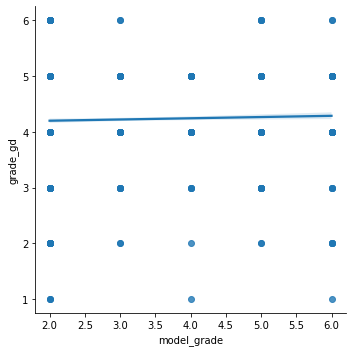

In [ ]:
sns.lmplot(data=odf,x = 'model_grade', y='grade_gd')

# sns.scatterplot(odf[odf.grade_st != 'None'].grade_gd.astype(int),odf[odf.grade_st != 'None'].scoreSTA)

<AxesSubplot:xlabel='grade_gd', ylabel='grade_st'>

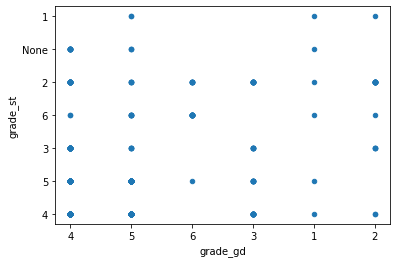

In [ ]:
odf.plot.scatter(x= 'grade_gd',y = 'grade_st')

In [ ]:
gd

['4_MD',
 '4_MD',
 '4_MD',
 '4_MD',
 '4_MD',
 '4_MD',
 '4_OA',
 '5_NF',
 '4_MD',
 '6_G',
 '4_OA',
 '4_MD',
 '4_MD',
 '4_MD',
 '4_MD',
 '5_NF',
 '5_NF',
 '4_MD',
 '4_MD',
 '4_MD',
 '4_MD',
 '4_MD',
 '5_NF',
 '4_MD',
 '5_MD',
 '4_MD',
 '4_MD',
 '5_NF',
 '4_OA',
 '4_MD',
 '5_MD',
 '5_NF',
 '5_NF',
 '5_NF',
 '4_OA',
 '4_MD',
 '4_MD',
 '4_MD',
 '4_MD',
 '5_NF',
 '4_MD',
 '5_NF',
 '4_MD',
 '4_OA',
 '4_MD',
 '4_MD',
 '4_MD',
 '4_MD',
 '5_MD',
 '4_MD',
 '6_G',
 '5_NF',
 '4_MD',
 '4_MD',
 '4_G',
 '4_MD',
 '4_MD',
 '4_MD',
 '4_MD',
 '4_MD',
 '4_MD',
 '5_NF',
 '5_NF',
 '5_NF',
 '5_NF',
 '4_MD',
 '5_NBT',
 '4_MD',
 '5_MD',
 '5_MD',
 '4_MD',
 '5_NF',
 '5_MD',
 '4_MD',
 '4_MD',
 '4_MD',
 '4_MD',
 '5_MD',
 '4_MD',
 '5_MD',
 '3_NBT',
 '4_MD',
 '4_MD',
 '4_MD',
 '4_MD',
 '5_NF',
 '3_G',
 '5_NF',
 '4_MD',
 '5_MD',
 '4_OA',
 '4_MD',
 '4_MD',
 '4_MD',
 '5_MD',
 '5_MD',
 '4_MD',
 '6_G',
 '5_MD',
 '4_MD',
 '4_MD',
 '5_NF',
 '4_MD',
 '4_MD',
 '3_G',
 '4_MD',
 '5_NF',
 '4_MD',
 '3_NBT',
 '4_MD',
 '4_MD',
 '4_

In [ ]:
texts = [[word for word in document.lower().split() if word not in stop_words]
         for document in corpus]
dictionary = corpora.Dictionary(texts)
corpus_gensim = [dictionary.doc2bow(text) for text in texts]
lsi_model = models.LsiModel(corpus_gensim, id2word=dictionary, num_topics=100)


corpus_lsi = lsi_model[corpus_gensim]
# texts =
texts_to_compare = ["\n".join(g.text) for ob, g in tdf.groupby('OBSID')]

# Tokenize and preprocess the texts to compare
texts_to_compare = [[word for word in document.lower().split() if word not in stop_words]
                    for document in texts_to_compare]

# Create Gensim corpus from the preprocessed texts
texts_to_compare_gensim = [dictionary.doc2bow(text) for text in texts_to_compare]

# Transform the texts to LSI space
texts_to_compare_lsi = lsi_model[texts_to_compare_gensim]

In [ ]:
index = similarities.MatrixSimilarity(corpus_lsi)

# Compute similarities between the corpus and the texts to compare
sims = index[texts_to_compare_lsi]

# Print the similarities
for i, (mlang, trans) in enumerate(zip(sims[:,0],sims[:,1])):

    # print(f"Text {i} similarity score: {mlang - trans:.2f}")
    print(mlang - trans)


0.7557719
0.6445167
-0.1828466
-0.056580424
0.5753503
0.3480494
0.6316639
0.6023128
0.5004339
0.17640936
0.48372197
0.61756086
0.52405524
0.4082247
0.59402895
0.061767995
-0.031814158
0.6597539
0.70425737
0.7575509
0.6681249
0.5637531
-0.20472944
0.43212157
0.22469252
0.35107523
0.5588021
0.3563993
0.8132228
0.39060694
0.4779953
0.32065833
0.17666507
0.19997573
0.60164225
0.29747558
0.44272324
0.4815809
0.108073235
0.30668855
0.28042018
0.5234153
0.44756934
0.7906585
0.42922652
0.6550193
0.63800085
0.535453
0.20370543
0.53826636
-0.34166294
0.60809714
0.0054961443
0.08822268
0.059336126
0.5370735
0.7170769
0.15088087
0.72969544
0.5405061
0.54865766
0.65874195
0.46142888
0.6248476
0.40816236
0.5553748
0.47891247
0.61486894
0.13268423
0.5117004
0.50425744
0.616754
0.72715914
0.57613957
0.36488372
0.30365223
0.10553473
-0.028377712
0.6797285
0.6276102
0.6065706
0.67973393
0.6271651
0.5208457
0.5182238
0.54656875
-0.07474077
0.5517608
0.4537596
0.51905715
0.62228966
0.6649486
0.6726014
0.6

In [ ]:
sns.scatterplot(df.groupby('OBSID').scoreSTA.mean(), sims[:,0] - sims[:,1])

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ValueError: ignored

In [ ]:
tdf.reset_index()[~tdf.OBSID.isin([4263,2065])].index

<ipython-input-42-16e99a9a7578>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tdf.reset_index()[~tdf.OBSID.isin([4263,2065])].index


IndexingError: ignored

In [ ]:
cdf.head()

,Unnamed: 0.2,Unnamed: 0,Unnamed: 0.1,grade,domain,cluster,standard,speaker,text,source,est_tok
0,0,0,0,K,MD,NaN,K.MD,teacher,what kinds of toys do you see?,talking_math,12
1,1,1,1,K,MD,NaN,K.MD,teacher,what can you tell me about the toys?,talking_math,12
2,2,2,4,K,MD,NaN,K.MD,teacher,how many toys are round? how many have straigh...,talking_math,16
3,3,3,5,K,MD,NaN,K.MD,teacher,do you think there are more round toys or toys...,talking_math,21
4,4,4,6,K,MD,NaN,1.MD,teacher,what kinds of toys do you see?,talking_math,12


In [ ]:
cdf.head()

,Unnamed: 0.2,Unnamed: 0,Unnamed: 0.1,grade,domain,cluster,standard,speaker,text,source,est_tok
0,0,0,0,K,MD,NaN,K.MD,teacher,what kinds of toys do you see?,talking_math,12
1,1,1,1,K,MD,NaN,K.MD,teacher,what can you tell me about the toys?,talking_math,12
2,2,2,4,K,MD,NaN,K.MD,teacher,how many toys are round? how many have straigh...,talking_math,16
3,3,3,5,K,MD,NaN,K.MD,teacher,do you think there are more round toys or toys...,talking_math,21
4,4,4,6,K,MD,NaN,1.MD,teacher,what kinds of toys do you see?,talking_math,12


## Simple comparison without rolling windows

In [ ]:
# The Gensim package
# !pip install gensim# The GSDMM implementation package
!pip install git+https://github.com/rwalk/gsdmm.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/rwalk/gsdmm.git to /tmp/pip-req-build-ekjzrb5m
  Running command git clone --filter=blob:none --quiet https://github.com/rwalk/gsdmm.git /tmp/pip-req-build-ekjzrb5m
  Resolved https://github.com/rwalk/gsdmm.git to commit 4ad1b6b6976743681ee4976b4573463d359214ee
  Preparing metadata (setup.py) ... done
  Created wheel for gsdmm: filename=gsdmm-0.1-py3-none-any.whl size=4601 sha256=092a12868a633d06abb479749f066991a59a0fb70dd442486f7c56c127412c34
  Stored in directory: /tmp/pip-ephem-wheel-cache-le5fcdxa/wheels/81/2c/23/3ff788bcc6063bf30116ad1a06e75d3ba9aad3f7bc4aba765b
Successfully built gsdmm


In [ ]:
import gsdmm
import numpy as np
import pandas as pd
import pickle
import re

from gsdmm import MovieGroupProcess
# from tqdm import tqdm

In [ ]:
%%time
# Train STTM model
#    K = number of potential topics
#    alpha = controls completeness
#    beta =  controls homogeneity
#    n_iters = number of iterations
# [dct.doc2bow(row) for row in sentences]

mgp = gsdmm.MovieGroupProcess(K=10, alpha=0.1, beta=0.5, n_iters=5)
vocab = set(x for line in cdf.text for x in utils.simple_preprocess(line))
n_terms = len(vocab)
y = mgp.fit(cdf.text, n_terms)

# Save model
with open(MODELS_FOLDER + '50clusters.model', 'wb') as f:
    pickle.dump(mgp, f)
    f.close()


In stage 0: transferred 74757 clusters with 10 clusters populated
In stage 1: transferred 53850 clusters with 10 clusters populated
In stage 2: transferred 25274 clusters with 10 clusters populated
In stage 3: transferred 14704 clusters with 8 clusters populated
In stage 4: transferred 12860 clusters with 8 clusters populated
CPU times: user 13min 34s, sys: 3.76 s, total: 13min 38s
Wall time: 13min 50s


In [ ]:
set(x for line in cdf.text for x in utils.simple_preprocess(line))

{'which',
 'popular',
 'funville',
 'swims',
 'happy',
 'confidence',
 'descending',
 'beam',
 'bit',
 'determined',
 'predict',
 'accurate',
 'affected',
 'centers',
 'revised',
 'tony',
 'slept',
 'poetry',
 'dm',
 'teller',
 'complete',
 'class',
 'ba',
 'satisfy',
 'stock',
 'pen',
 'towards',
 'lemonade',
 'radicals',
 'stacked',
 'geometric',
 'protractor',
 'jadyn',
 'basically',
 'porches',
 'everywhere',
 'language',
 'floors',
 'clayton',
 'gardening',
 'seriously',
 'decompositions',
 'winner',
 'touched',
 'converted',
 'designers',
 'numeral',
 'setting',
 'drill',
 'mentally',
 'mathematicians',
 'whirl',
 'merge',
 'makes',
 'messiness',
 'tablespoons',
 'groupmates',
 'palace',
 'proof',
 'bizarre',
 'previously',
 'pedmas',
 'overlaps',
 'billion',
 'reflect',
 'greenc',
 'rough',
 'noun',
 'chris',
 'tires',
 'cousin',
 'cornered',
 'handwriting',
 'careers',
 'anytime',
 'tastes',
 'vertically',
 'chunks',
 'joe',
 'adrian',
 'important',
 'eraser',
 'calculating',
 

In [ ]:
# cdf.head()

,grade,domain,cluster,standard,speaker,text,source,est_tok
0,K,MD,NaN,K.MD,teacher,what kinds of toys do you see?,talking_math,12
1,K,MD,NaN,K.MD,teacher,what can you tell me about the toys?,talking_math,12
2,K,MD,NaN,K.MD,teacher,how many toys are round? how many have straigh...,talking_math,16
3,K,MD,NaN,K.MD,teacher,do you think there are more round toys or toys...,talking_math,21
4,K,MD,NaN,1.MD,teacher,what kinds of toys do you see?,talking_math,12


In [ ]:
# load in trained model
filehandler = open('50clusters.model', 'rb')
mgp = pickle.load(filehandler)

In [ ]:


# define helper functions
def top_words(cluster_word_distribution, top_cluster, values):
    '''prints the top words in each cluster'''
    for cluster in top_cluster:
        sort_dicts =sorted(mgp.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print('Cluster %s : %s'%(cluster,sort_dicts))
        print(' — — — — — — — — —')

def cluster_importance(mgp):
    '''returns a word-topic matrix[phi] where each value represents
    the word importance for that particular cluster;
    phi[i][w] would be the importance of word w in topic i.
    '''
    n_z_w = mgp.cluster_word_distribution
    beta, V, K = mgp.beta, mgp.vocab_size, mgp.K
    phi = [{} for i in range(K)]
    for z in range(K):
        for w in n_z_w[z]:
            phi[z][w] = (n_z_w[z][w]+beta)/(sum(n_z_w[z].values())+V*beta)
    return phi

def topic_allocation(df, docs, mgp, topic_dict):
    '''allocates all topics to each document in original dataframe,
    adding two columns for cluster number and cluster description'''
    topic_allocations = []
    for doc in tqdm(docs):
        topic_label, score = mgp.choose_best_label(doc)
        topic_allocations.append(topic_label)

    df['cluster'] = topic_allocations

    df['topic_name'] = df.cluster.apply(lambda x: get_topic_name(x, topic_dict))
    print('Complete. Number of documents with topic allocated: {}'.format(len(df)))

def get_topic_name(doc, topic_dict):
    '''returns the topic name string value from a dictionary of topics'''
    topic_desc = topic_dict[doc]
    return topic_desc

# helper functions to extract all data needed to create bubble charts for exploring words in each topic
def top_words_dict(cluster_word_distribution, top_cluster, n_words):
    '''returns a dictionary of the top n words and the number of docs they are in;
    cluster numbers are the keys and a tuple of (word, word count) are the values'''
    top_words_dict = {}
    for cluster in top_cluster:
        top_words_list = []
        for val in range(0, n_words):
            top_n_word = sorted(mgp.cluster_word_distribution[cluster].items(),
                                key=lambda item: item[1], reverse=True)[:n_words][val]    #[0]
            top_words_list.append(top_n_word)
        top_words_dict[cluster] = top_words_list

    return top_words_dict

def get_word_counts_dict(top_words_nclusters):
    '''returns a dictionary that counts the number of times a word
    appears only in the top n words list across all the clusters;
    words are the keys and a count of the word is the value'''
    word_count_dict = {}
    for key in top_words_nclusters:
        words_score_list = []
        for word in top_words_nclusters[key]:
            if word[0] in word_count_dict.keys():
                word_count_dict[word[0]] += 1
            else:
                word_count_dict[word[0]] = 1
    return word_count_dict

def get_cluster_importance_dict(top_words_nclusters, phi):
    '''returns a dictionary that of all top words and their cluster
    importance value for each cluster;
    cluster numbers are the keys and a list of word
    importance computed scores are the values'''
    cluster_importance_dict = {}
    for key in top_words_nclusters:
        words_score_list = []
        for word in top_words_nclusters[key]:
            importance_score = phi[key][word[0]]
            words_score_list.append(importance_score)
        cluster_importance_dict[key] = words_score_list
    return cluster_importance_dict

def get_doc_counts_dict(top_words_nclusters):
    '''returns a dictionary of only the doc counts of each top n word for each cluster;
    cluster numbers are the keys and a list of doc counts are the values'''
    doc_counts_dict = {}
    for key in top_words_nclusters:
        doc_counts_list = []
        for word in top_words_nclusters[key]:
            num_docs = word[1]
            doc_counts_list.append(num_docs)
        doc_counts_dict[key] = doc_counts_list
    return doc_counts_dict

def get_word_frequency_dict(top_words_nclusters, word_counts):
    '''returns a dictionary of only the number of occurences across all
    clusters for each word in a particular cluster's top n words;
    cluster numbers are the keys and a list of
    word occurences counts are the values'''
    word_frequency_dict = {}
    for key in top_words_nclusters:
        words_count_list = []
        for word in top_words_nclusters[key]:
            words_count_list.append(word_counts[word[0]])
        word_frequency_dict[key] = words_count_list

    return word_frequency_dict



In [ ]:
doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topic :', doc_count)
print('*'*20)

# topics sorted by the number of documents they are allocated to
top_index = doc_count.argsort()[-50:][::-1]
print('Most important clusters (by number of docs inside):', top_index)
print('*'*20)

# show the top 5 words in term frequency for each cluster
topic_indices = np.arange(start=0, stop=len(doc_count), step=1)
top_words(mgp.cluster_word_distribution, topic_indices, 5)



Number of documents per topic : [12049     0     0  1385  7759  9882  8411  4892 29642  9108]
********************
Most important clusters (by number of docs inside): [8 0 5 9 6 4 7 3 2 1]
********************
Cluster 0 : [(' ', 184311), ('e', 94062), ('t', 74539), ('a', 58912), ('o', 55543)]
 — — — — — — — — —
Cluster 1 : []
 — — — — — — — — —
Cluster 2 : []
 — — — — — — — — —
Cluster 3 : [(' ', 16171), ('e', 7775), ('t', 5796), ('a', 4459), ('o', 4136)]
 — — — — — — — — —
Cluster 4 : [(' ', 96419), ('e', 34394), ('t', 30334), ('i', 23898), ('a', 23875)]
 — — — — — — — — —
Cluster 5 : [(' ', 120389), ('e', 41492), ('t', 37571), ('s', 34201), ('i', 32449)]
 — — — — — — — — —
Cluster 6 : [(' ', 109189), ('e', 42990), ('t', 35190), ('a', 28630), ('o', 26462)]
 — — — — — — — — —
Cluster 7 : [(' ', 41632), ('N', 27054), ('M', 19215), ('U', 19209), (',', 11325)]
 — — — — — — — — —
Cluster 8 : [(' ', 352403), ('e', 192381), ('t', 165283), ('a', 127145), ('o', 124557)]
 — — — — — — — — —
Clus

In [ ]:
# declare any static variables needed
nwords = 10
nclusters = 50 # len(topic_names)
phi = cluster_importance(mgp)

# define and generate dictionaries that hold each topic number and its values
top_words = top_words_dict(mgp.cluster_word_distribution, topic_indices, nwords)
word_count = get_word_counts_dict(top_words)
word_frequency = get_word_frequency_dict(top_words, word_count)
cluster_importance_dict = get_cluster_importance_dict(top_words, phi)

# add all values for each topic to a list of lists
rows_list = []
for cluster in range(0, nclusters):
    topic_name = topic_names[cluster]
    words = [x[0] for x in top_words[cluster]]
    doc_counts = [x[1] for x in top_words[cluster]]

    # create a list of values which represents a 'row' in our data frame
    rows_list.append([int(cluster), topic_name, words, doc_counts,
                     word_frequency[cluster], cluster_importance_dict[cluster]])

topic_words_df = pd.DataFrame(data=rows_list,
                              columns=['cluster','topic_name', 'top_words',
                                        'doc_count', 'num_topic_occurrence', 'word_importance'])

topic_words_df

NameError: ignored

In [ ]:
def create_topics_dataframe(data_text=data.Review,  mgp=mgp, threshold=0.3, topic_dict=topic_dict, lemma_text=reviews_lemmatized):
    result = pd.DataFrame(columns=['Text', 'Topic', 'Rating', 'Lemma-text'])
    for i, text in enumerate(data_text):
        result.at[i, 'Text'] = text
        result.at[i, 'Rating'] = data.Rating[i]
        result.at[i, 'Lemma-text'] = lemma_text[i]
        prob = mgp.choose_best_label(reviews_lemmatized[i])
        if prob[1] >= threshold:
            result.at[i, 'Topic'] = topic_dict[prob[0]]
        else:
            result.at[i, 'Topic'] = 'Other'
    return result

In [ ]:
corpus = [dct.doc2bow(row) for row in sentences]

In [ ]:
len(corpus)

83128